In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --pre pycaret

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import tensorflow as tf
from tensorflow.keras import layers
import json

In [ ]:
from pycaret.classification import *

In [ ]:
json_path = "/content/drive/MyDrive/protein_props.json"
with open(json_path) as f:
  data = json.load(f)
len(data)

20434

In [ ]:
okk = pd.read_json(json_path)
properties = okk.transpose()

In [ ]:
druggable_data = "/content/drive/MyDrive/druggable_proteins.txt"
with open(druggable_data) as f:
  druggable_proteins = [line.strip() for line in f]
print(len(druggable_proteins))

approved_drugs = "/content/drive/MyDrive/approved_druggable_proteins.txt"
with open(approved_drugs) as g:
  approved_proteins = [line.strip() for line in g]
print(len(approved_proteins))

3345
2652


In [ ]:
index = 'A C D E F G H I K L M N P Q R S T V W Y'
for i in index.split(" "):
  properties[f"Amino_Acid_{i}_Percent"] = pd.Series([0]*properties.shape[0])
properties['Molar Extinction Coefficient 1'] = pd.Series([0]*properties.shape[0])
properties['Molar Extinction Coefficient 2'] = pd.Series([0]*properties.shape[0])
properties['Secondary Structure helix'] = pd.Series([0]*properties.shape[0])
properties['Secondary Structure turn'] = pd.Series([0]*properties.shape[0])
properties['Secondary Structure sheet'] = pd.Series([0]*properties.shape[0])
for i in range(properties.shape[0]):
  for j,k in properties['Amino Acid Percent'][i].items():
    properties[f"Amino_Acid_{j}_Percent"][i] = k
  properties['Molar Extinction Coefficient 1'][i] = properties['Molar Extinction Coefficient'][i][0]
  properties['Molar Extinction Coefficient 2'][i] = properties['Molar Extinction Coefficient'][i][1]
  properties['Secondary Structure helix'][i] = properties['Secondary Structure'][i][0]
  properties['Secondary Structure turn'][i] = properties['Secondary Structure'][i][1]
  properties['Secondary Structure sheet'][i] = properties['Secondary Structure'][i][2]
properties.drop(columns = ['Sequence','Amino Acid Count','Amino Acid Percent','Molar Extinction Coefficient','Secondary Structure'],axis = 1, inplace = True)

In [ ]:
is_druggable = []
for i in properties.index:
  if i in druggable_proteins:
    is_druggable.append(1)
  else:
    is_druggable.append(0)

approved_drugs = []
for j in properties.index:
  if j in approved_proteins:
    approved_drugs.append(1)
  else:
    approved_drugs.append(0)

properties['is_druggable'] = is_druggable
properties['is_approved'] = approved_drugs
properties


Sequence Length Molecular Weight     GRAVY Isoelectric Point  \
A0A087X1C5             515       57488.0269 -0.016117          8.703506   
A0A0B4J2F0              54        6313.3024 -0.235185           8.03542   
A0A0B4J2F2             783       84929.1856 -0.197957          6.813029   
A0A0C5B5G6              16        2174.5917   -0.9375         10.266413   
A0A0K2S4Q6             201       21805.9293   0.10796          5.366988   
...                    ...              ...       ...               ...   
Q9UI54                  55         6386.613  0.303636         10.302902   
Q9UI72                  69        8249.2539 -1.015942          9.348383   
Q9Y3F1                  56        6534.5215  0.444643          4.493088   
Q9Y6C7                  94       11023.7471 -0.029787         10.192468   
Q9Y6Z2                  57        6188.8293 -0.421053          5.982781   

           Instability Index Aromaticity  \
A0A087X1C5         45.155922    0.085437   
A0A0B4J2F0         55.518519     0.12963   
A0A0B4J2F2         59.277803    0.063857   
A0A0C5B5G6         77.300625        0.25   
A0A0K2S4Q6         41.796517    0.074627   
...                      ...         ...   
Q9UI54             35.789091    0.145455   
Q9UI72             46.171014    0.101449   
Q9Y3F1                69.675    0.196429   
Q9Y6C7             62.375638    0.117021   
Q9Y6Z2                  50.3    0.087719   

                                                  Flexibility Charge at 7  \
A0A087X1C5  [0.977440476190476, 0.9806071428571421, 0.9983...    5.889114   
A0A0B4J2F0  [0.982095238095238, 0.95625, 0.983214285714285...    0.510326   
A0A0B4J2F2  [1.00125, 0.970071428571428, 1.034523809523809...   -1.004586   
A0A0C5B5G6  [0.9704047619047621, 1.00345238095238, 0.95860...    2.500138   
A0A0K2S4Q6  [1.008285714285714, 0.9868928571428571, 0.991,...   -3.378625   
...                                                       ...         ...   
Q9UI54      [0.9746904761904761, 1.00325, 0.98202380952380...    7.571427   
Q9UI72      [1.006333333333333, 0.9435238095238091, 0.9573...    3.659009   
Q9Y3F1      [0.988154761904761, 0.9863214285714281, 0.9781...     -2.5132   
Q9Y6C7      [0.9616666666666661, 1.001988095238095, 0.9683...    6.176832   
Q9Y6Z2      [1.00745238095238, 0.9976309523809521, 0.97805...   -2.154883   

            Amino_Acid_A_Percent  Amino_Acid_C_Percent  ...  \
A0A087X1C5              0.081553              0.017476  ...   
A0A0B4J2F0              0.074074              0.000000  ...   
A0A0B4J2F2              0.084291              0.024266  ...   
A0A0C5B5G6              0.000000              0.000000  ...   
A0A0K2S4Q6              0.054726              0.039801  ...   
...                          ...                   ...  ...   
Q9UI54                  0.018182              0.018182  ...   
Q9UI72                  0.057971              0.043478  ...   
Q9Y3F1                  0.035714              0.035714  ...   
Q9Y6C7                  0.042553              0.021277  ...   
Q9Y6Z2                  0.070175              0.017544  ...   

            Amino_Acid_V_Percent  Amino_Acid_W_Percent  Amino_Acid_Y_Percent  \
A0A087X1C5              0.085437              0.013592              0.011650   
A0A0B4J2F0              0.074074              0.000000              0.037037   
A0A0B4J2F2              0.053640              0.007663              0.020434   
A0A0C5B5G6              0.000000              0.062500              0.125000   
A0A0K2S4Q6              0.079602              0.024876              0.019900   
...                          ...                   ...                   ...   
Q9UI54                  0.054545              0.000000              0.036364   
Q9UI72                  0.014493              0.028986              0.043478   
Q9Y3F1                  0.017857              0.035714              0.053571   
Q9Y6C7                  0.031915              0.042553              0.021277   
Q9Y6Z2             

In [ ]:
data = properties.drop(['Flexibility'],axis = 1)
data

Sequence Length Molecular Weight     GRAVY Isoelectric Point  \
A0A087X1C5             515       57488.0269 -0.016117          8.703506   
A0A0B4J2F0              54        6313.3024 -0.235185           8.03542   
A0A0B4J2F2             783       84929.1856 -0.197957          6.813029   
A0A0C5B5G6              16        2174.5917   -0.9375         10.266413   
A0A0K2S4Q6             201       21805.9293   0.10796          5.366988   
...                    ...              ...       ...               ...   
Q9UI54                  55         6386.613  0.303636         10.302902   
Q9UI72                  69        8249.2539 -1.015942          9.348383   
Q9Y3F1                  56        6534.5215  0.444643          4.493088   
Q9Y6C7                  94       11023.7471 -0.029787         10.192468   
Q9Y6Z2                  57        6188.8293 -0.421053          5.982781   

           Instability Index Aromaticity Charge at 7  Amino_Acid_A_Percent  \
A0A087X1C5         45.155922    0.085437    5.889114              0.081553   
A0A0B4J2F0         55.518519     0.12963    0.510326              0.074074   
A0A0B4J2F2         59.277803    0.063857   -1.004586              0.084291   
A0A0C5B5G6         77.300625        0.25    2.500138              0.000000   
A0A0K2S4Q6         41.796517    0.074627   -3.378625              0.054726   
...                      ...         ...         ...                   ...   
Q9UI54             35.789091    0.145455    7.571427              0.018182   
Q9UI72             46.171014    0.101449    3.659009              0.057971   
Q9Y3F1                69.675    0.196429     -2.5132              0.035714   
Q9Y6C7             62.375638    0.117021    6.176832              0.042553   
Q9Y6Z2                  50.3    0.087719   -2.154883              0.070175   

            Amino_Acid_C_Percent  Amino_Acid_D_Percent  ...  \
A0A087X1C5              0.017476              0.044660  ...   
A0A0B4J2F0              0.000000              0.018519  ...   
A0A0B4J2F2              0.024266              0.038314  ...   
A0A0C5B5G6              0.000000              0.000000  ...   
A0A0K2S4Q6              0.039801              0.034826  ...   
...                          ...                   ...  ...   
Q9UI54                  0.018182              0.000000  ...   
Q9UI72                  0.043478              0.028986  ...   
Q9Y3F1                  0.035714              0.000000  ...   
Q9Y6C7                  0.021277              0.010638  ...   
Q9Y6Z2                  0.017544              0.052632  ...   

            Amino_Acid_V_Percent  Amino_Acid_W_Percent  Amino_Acid_Y_Percent  \
A0A087X1C5              0.085437              0.013592              0.011650   
A0A0B4J2F0              0.074074              0.000000              0.037037   
A0A0B4J2F2              0.053640              0.007663              0.020434   
A0A0C5B5G6              0.000000              0.062500              0.125000   
A0A0K2S4Q6              0.079602              0.024876              0.019900   
...                          ...                   ...                   ...   
Q9UI54                  0.054545              0.000000              0.036364   
Q9UI72                  0.014493              0.028986              0.043478   
Q9Y3F1                  0.017857              0.035714              0.053571   
Q9Y6C7                  0.031915              0.042553              0.021277   
Q9Y6Z2                  0.052632              0.017544              0.035088   

            Molar Extinction Coefficient 1  Molar Extinction Coefficient 2  \
A0A087X1C5                         47440.0                         47940.0   
A0A0B4J2F0                          2980.0                          2980.0   
A0A0B4J2F2                         56840.0                         57965.0   
A0A0C5B5G6                          8480.0                          8480.0   
A0A0K2S4Q6                         33460.0                       

In [ ]:
data[data.columns[0:7]] = data[data.columns[0:7]].astype(float)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 20434 entries, A0A087X1C5 to Q9Y6Z2
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Sequence Length                 20434 non-null  float64
 1   Molecular Weight                20434 non-null  float64
 2   GRAVY                           20434 non-null  float64
 3   Isoelectric Point               20434 non-null  float64
 4   Instability Index               20434 non-null  float64
 5   Aromaticity                     20434 non-null  float64
 6   Charge at 7                     20434 non-null  float64
 7   Amino_Acid_A_Percent            20434 non-null  float64
 8   Amino_Acid_C_Percent            20434 non-null  float64
 9   Amino_Acid_D_Percent            20434 non-null  float64
 10  Amino_Acid_E_Percent            20434 non-null  float64
 11  Amino_Acid_F_Percent            20434 non-null  float64
 12  Amino_Acid_G_Percent       

In [ ]:
data.isna().sum().sum()

0

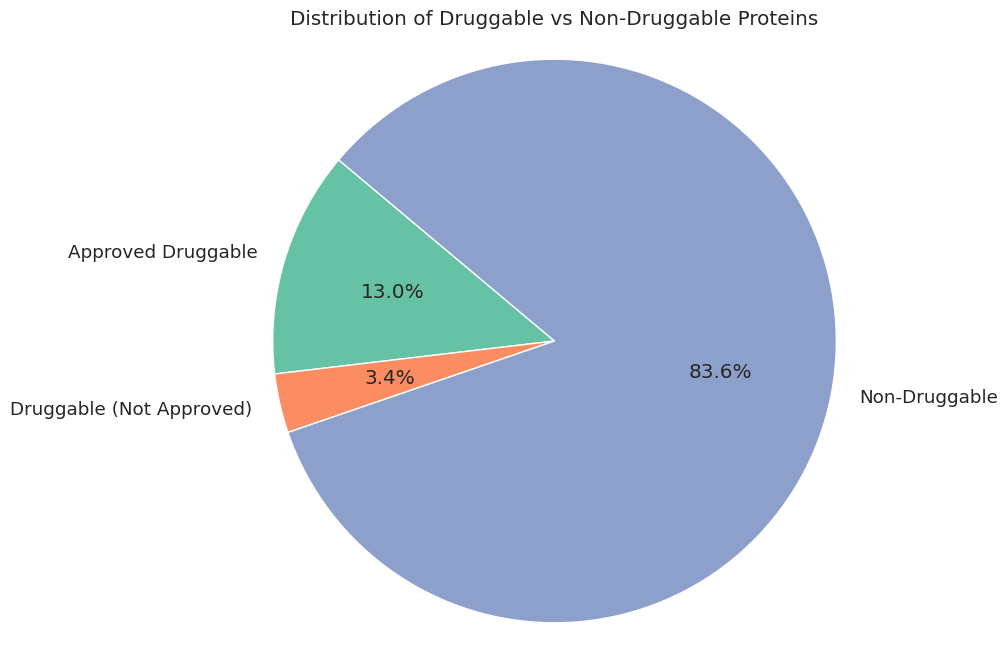

In [ ]:
druggable_counts = properties['is_druggable'].value_counts()

druggable_df = properties[properties['is_druggable'] == 1]
approved_druggable_count = druggable_df['is_approved'].sum()

total_proteins = properties.shape[0]

non_druggable_count = total_proteins - druggable_counts[1]
non_approved_druggable_count = druggable_counts[1] - approved_druggable_count

# Plotting
plt.figure(figsize=(8, 8))
plt.pie([approved_druggable_count, non_approved_druggable_count, non_druggable_count], labels=['Approved Druggable', 'Druggable (Not Approved)', 'Non-Druggable'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Distribution of Druggable vs Non-Druggable Proteins')
plt.axis('equal')
plt.show()

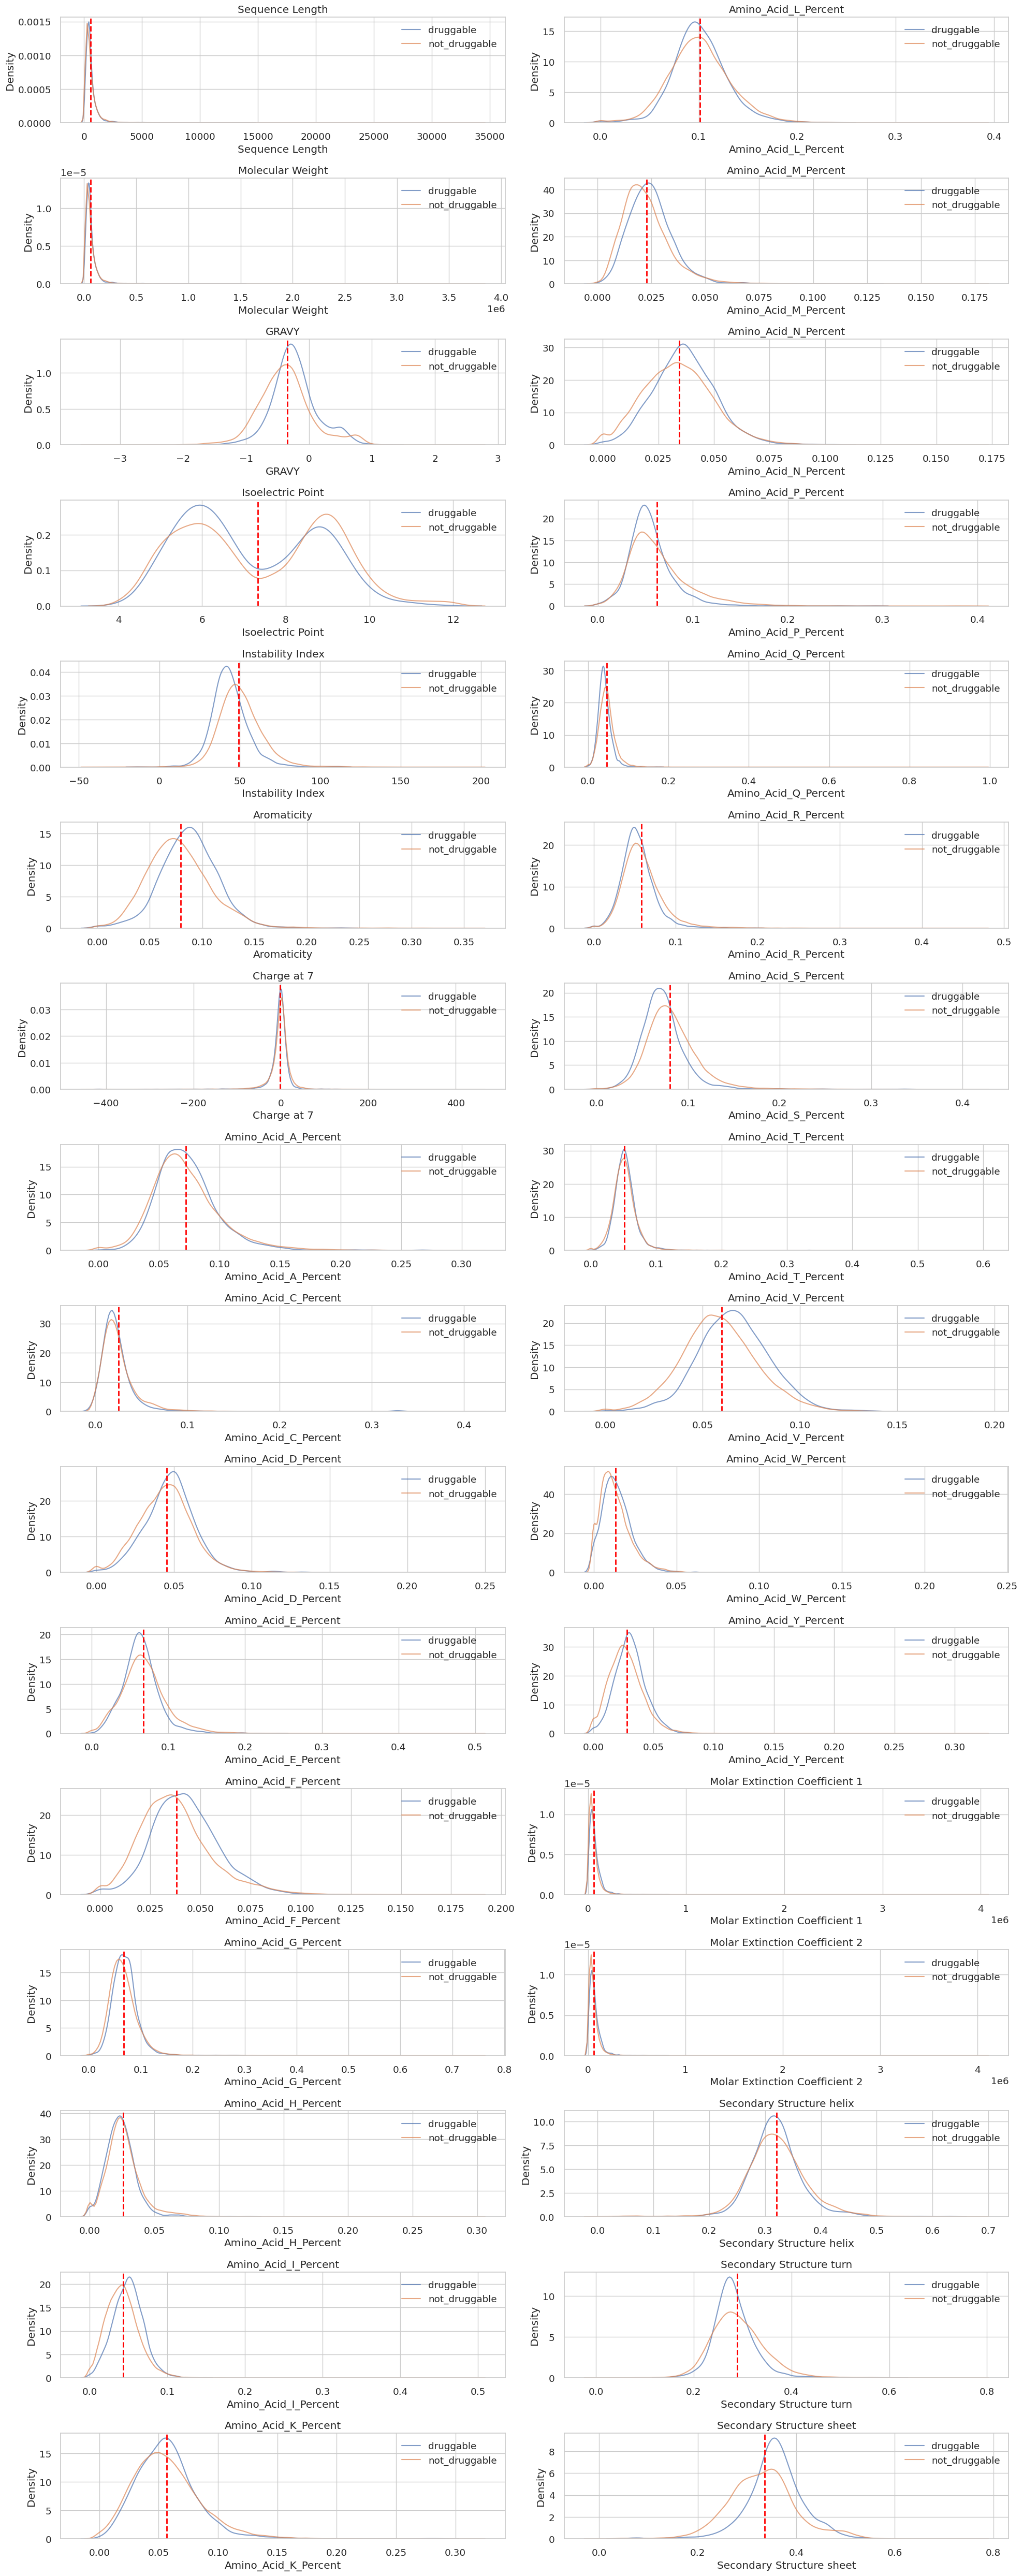

In [ ]:
fig,ax = plt.subplots(figsize = (20,50),nrows = 16,ncols = 2)
for i,values in enumerate(data.columns[:-2]):
  if i <16:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label = 'druggable')
    sns.kdeplot(data = data[data['is_druggable'] == 0], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label ='not_druggable')
    ax[i][0].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i][0].set_title(values)
    ax[i][0].legend()
  else:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i-16][1],alpha = 0.7,common_norm = True,label = 'druggable')
    sns.kdeplot(data=data[data['is_druggable'] == 0], x=values, ax=ax[i-16][1],alpha = 0.7,common_norm = True,label ='not_druggable')
    ax[i-16][1].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i-16][1].set_title(values)
    ax[i-16][1].legend()

plt.tight_layout()
plt.show()

In [ ]:
data.describe()

Sequence Length  Molecular Weight         GRAVY  Isoelectric Point  \
count     20434.000000      2.043400e+04  20434.000000       20434.000000   
mean        558.350152      6.218838e+04     -0.343600           7.329772   
std         606.567158      6.708417e+04      0.430772           1.754309   
min           2.000000      2.602869e+02     -3.432500           4.050028   
25%         249.000000      2.775125e+04     -0.604473           5.802119   
50%         415.000000      4.619810e+04     -0.362563           7.059653   
75%         670.000000      7.482271e+04     -0.131380           8.885194   
max       34350.000000      3.815983e+06      2.608000          11.999968   

       Instability Index   Aromaticity   Charge at 7  Amino_Acid_A_Percent  \
count       20434.000000  20434.000000  20434.000000          20434.000000   
mean           49.419399      0.079209     -1.912736              0.072052   
std            13.373352      0.030165     22.825295              0.027747   
min           -42.940000      0.000000   -447.417559              0.000000   
25%            40.892744      0.058824     -8.026765              0.053946   
50%            48.131515      0.077367      0.213363              0.068340   
75%            56.548763      0.097046      7.268414              0.085911   
max           196.717500      0.357143    457.297097              0.307229   

       Amino_Acid_C_Percent  Amino_Acid_D_Percent  ...  Amino_Acid_V_Percent  \
count          20434.000000          20434.000000  ...          20434.000000   
mean               0.025376              0.045246  ...              0.059924   
std                0.026146              0.017634  ...              0.019620   
min                0.000000              0.000000  ...              0.000000   
25%                0.013058              0.033898  ...              0.047138   
50%                0.020528              0.045356  ...              0.059211   
75%                0.030172              0.055556  ...              0.071983   
max                0.411765              0.242424  ...              0.188525   

       Amino_Acid_W_Percent  Amino_Acid_Y_Percent  \
count          20434.000000          20434.000000   
mean               0.013143              0.027888   
std                0.009426              0.015154   
min                0.000000              0.000000   
25%                0.006500              0.018116   
50%                0.011538              0.026743   
75%                0.017857              0.035912   
max                0.232877              0.321429   

       Molar Extinction Coefficient 1  Molar Extinction Coefficient 2  \
count                    2.043400e+04                    2.043400e+04   
mean                     5.938539e+04                    6.015646e+04   
std                      6.554780e+04                    6.626062e+04   
min                      0.000000e+00                    0.000000e+00   
25%                      2.487000e+04                    2.521875e+04   
50%                      4.446000e+04                    4.518500e+04   
75%                      7.483000e+04                    7.577500e+04   
max                      4.051510e+06                    4.083510e+06   

       Secondary Structure helix  Secondary Structure turn  \
count               20434.000000              20434.000000   
mean                    0.320547                  0.289585   
std                     0.054092                  0.053513   
min                     0.000000                  0.000000   
25%                     0.289855                  0.255047   
50%                     0.318111                  0.283897   
75%                     0.349491                  0.318875   
max                     0.676471                  0.779400   

       Secondary Structure sheet  is_druggable   is_approved  
count               20434.000000  20434.000000  20434.000000  
mean                    0.335513      0.163698      0.129784  
std  

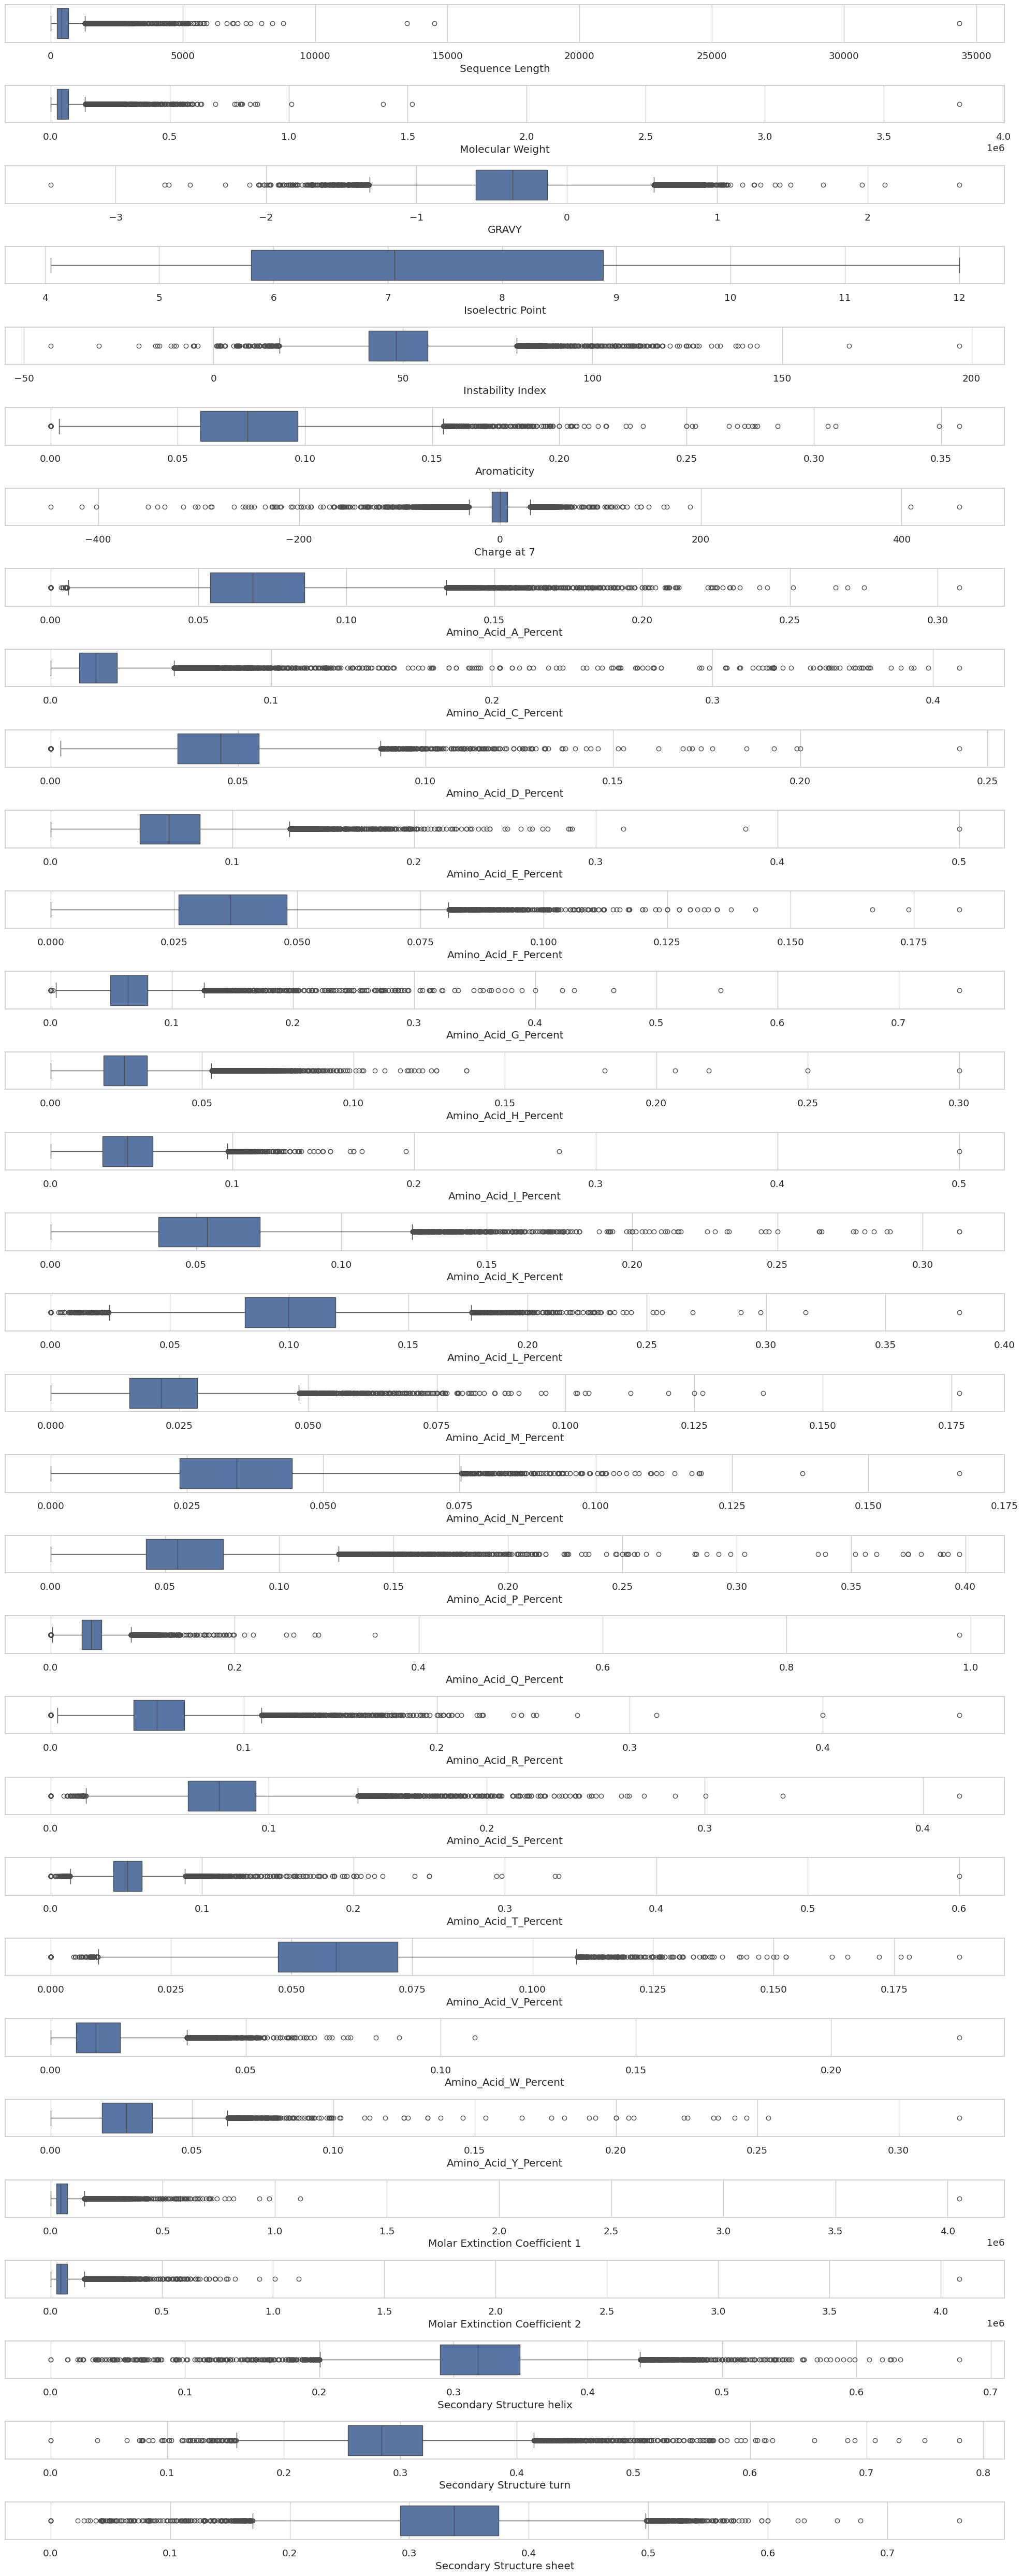

In [ ]:
fig,ax = plt.subplots(figsize = (20,50), nrows = 32)
for i,values in enumerate(data.columns[:-2]):
  sns.boxplot(data[values], orient = 'h',ax = ax[i])
plt.tight_layout()
plt.show()

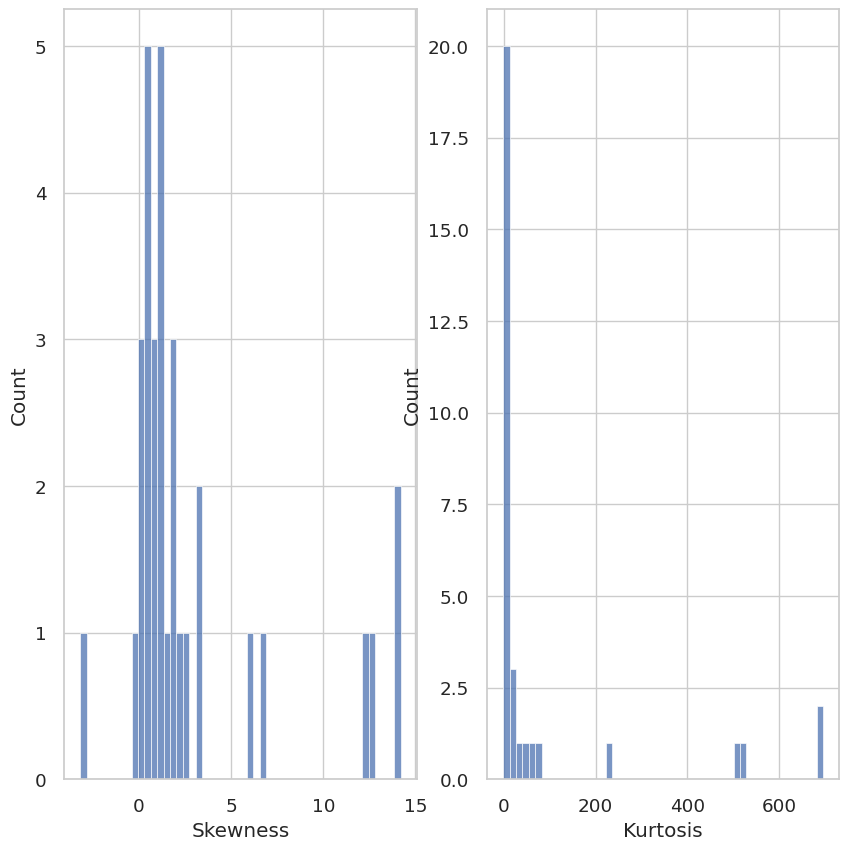

In [ ]:
okk = {
    "Skewness" : pd.Series(data[data.columns[:-2]].skew()),
    "Kurtosis" : pd.Series(data[data.columns[:-2]].kurtosis())
}
stats = pd.DataFrame(okk)
fig,ax = plt.subplots(figsize = (10,10),ncols = 2)
sns.histplot(stats['Skewness'],bins = 50, ax =ax[0])
sns.histplot(stats['Kurtosis'],bins = 50, ax =ax[1])
plt.show()

In [ ]:
normalized_need_column = stats[(abs(stats["Skewness"]) > 2.5) & (stats['Kurtosis'] > 10)]
normalized_need_column

Skewness    Kurtosis
Sequence Length                 12.467282  513.166402
Molecular Weight                12.396958  516.335435
Charge at 7                     -3.166890   61.028859
Amino_Acid_C_Percent             6.660513   69.495041
Amino_Acid_G_Percent             3.290374   33.704503
Amino_Acid_Q_Percent             6.181852  224.694268
Amino_Acid_T_Percent             3.206956   54.074455
Molar Extinction Coefficient 1  14.193814  695.545705
Molar Extinction Coefficient 2  14.113224  687.684901

In [ ]:
# data[data.columns[:-2]] = np.log1p(data[data.columns[:-2]])
# data

In [ ]:
# fig,ax = plt.subplots(figsize = (20,50),nrows = 16,ncols = 2)
# for i,values in enumerate(data.columns[:-2]):
#   if i <16:
#     sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label = 'druggable')
#     sns.kdeplot(data = data[data['is_druggable'] == 0], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label ='not_druggable')
#     ax[i][0].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
#     ax[i][0].set_title(values)
#     ax[i][0].legend()
#   else:
#     sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i-16][1],alpha = 0.7,common_norm = True,label = 'druggable')
#     sns.kdeplot(data=data[data['is_druggable'] == 0], x=values, ax=ax[i-16][1],alpha = 0.7,common_norm = True,label ='not_druggable')
#     ax[i-16][1].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
#     ax[i-16][1].set_title(values)
#     ax[i-16][1].legend()

# plt.tight_layout()
# plt.show()

In [ ]:
#scaling of data on same scale for further analysis(Z-score normalization)
std_scale = StandardScaler()
data[data.columns[:-2]] = std_scale.fit_transform(data[data.columns[:-2]])
data

Sequence Length  Molecular Weight     GRAVY  Isoelectric Point  \
A0A087X1C5        -0.071470         -0.070068  0.760243           0.783081   
A0A0B4J2F0        -0.831503         -0.832930  0.251681           0.402247   
A0A0B4J2F2         0.370372          0.338997  0.338107          -0.294564   
A0A0C5B5G6        -0.894152         -0.894626 -1.378722           1.673999   
A0A0K2S4Q6        -0.589150         -0.601982  1.048284          -1.118863   
...                     ...               ...       ...                ...   
Q9UI54            -0.829854         -0.831837  1.502540           1.694799   
Q9UI72            -0.806773         -0.804071 -1.560823           1.150686   
Q9Y3F1            -0.828206         -0.829633  1.829883          -1.617020   
Q9Y6C7            -0.765557         -0.762712  0.728507           1.631847   
Q9Y6Z2            -0.826557         -0.834786 -0.179805          -0.767837   

            Instability Index  Aromaticity  Charge at 7  Amino_Acid_A_Percent  \
A0A087X1C5          -0.318812     0.206465     0.341816              0.342421   
A0A0B4J2F0           0.456076     1.671528     0.106160              0.072864   
A0A0B4J2F2           0.737186    -0.508946     0.039788              0.441092   
A0A0C5B5G6           2.084886     5.662007     0.193337             -2.596787   
A0A0K2S4Q6          -0.570019    -0.151906    -0.064224             -0.624433   
...                       ...          ...          ...                   ...   
Q9UI54              -1.019239     2.196150     0.415521             -1.941509   
Q9UI72              -0.242906     0.737302     0.244110             -0.507495   
Q9Y3F1               1.514661     3.886024    -0.026308             -1.309634   
Q9Y6C7               0.968834     1.253540     0.354421             -1.063158   
Q9Y6Z2               0.065849     0.282130    -0.010609             -0.067644   

            Amino_Acid_C_Percent  Amino_Acid_D_Percent  ...  \
A0A087X1C5             -0.302177             -0.033219  ...   
A0A0B4J2F0             -0.970587             -1.515677  ...   
A0A0B4J2F2             -0.042476             -0.393093  ...   
A0A0C5B5G6             -0.970587             -2.565837  ...   
A0A0K2S4Q6              0.551718             -0.590910  ...   
...                          ...                   ...  ...   
Q9UI54                 -0.275170             -2.565837  ...   
Q9UI72                  0.692366             -0.922108  ...   
Q9Y3F1                  0.395410             -2.565837  ...   
Q9Y6C7                 -0.156801             -1.962553  ...   
Q9Y6Z2                 -0.299571              0.418828  ...   

            Amino_Acid_V_Percent  Amino_Acid_W_Percent  Amino_Acid_Y_Percent  \
A0A087X1C5              1.300386              0.047635             -1.071593   
A0A0B4J2F0              0.721231             -1.394374              0.603738   
A0A0B4J2F2             -0.320287             -0.581419             -0.491929   
A0A0C5B5G6             -3.054272              5.236294              6.408663   
A0A0K2S4Q6              1.002985              1.244698             -0.527151   
...                          ...                   ...                   ...   
Q9UI54                 -0.274129             -1.394374              0.559298   
Q9UI72                 -2.315587              1.680718              1.028813   
Q9Y3F1                 -2.144106              2.394579              1.694889   
Q9Y6C7                 -1.427593              3.120123             -0.436338   
Q9Y6Z2                 -0.371678              0.466866              0.475097   

            Molar Extinction Coefficient 1  Molar Extinction Coefficient 2  \
A0A087X1C5                       -0.182244                       -0.184374   
A0A0B4J2F0                       -0.860544                       -0.862924   
A0A0B4J2F2                       -0.038834                       -0.033074   
A0A0C5B5G6                       -0.776634                       -0.7799

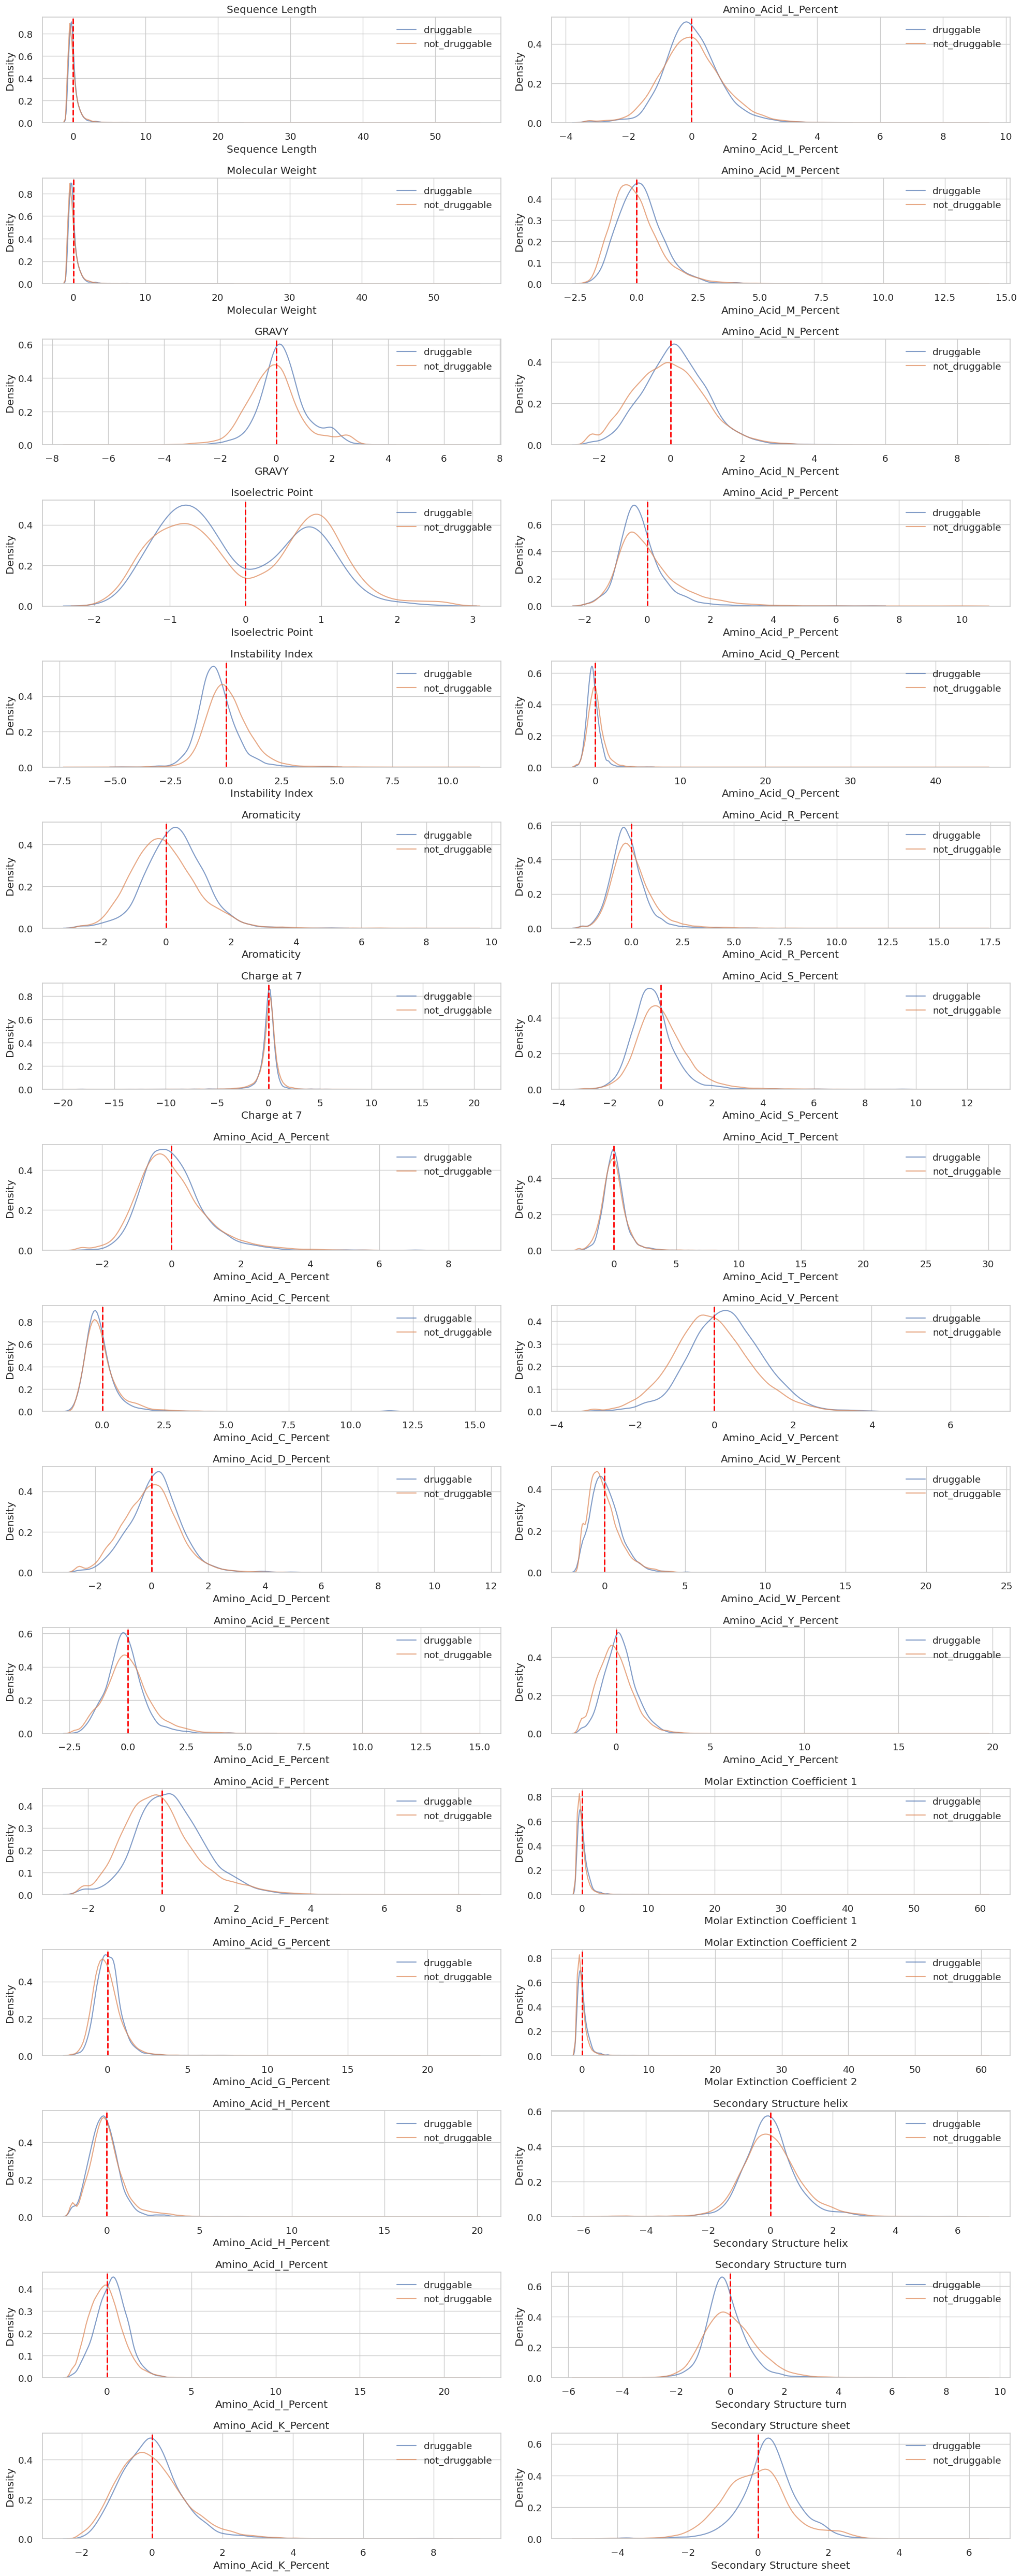

In [ ]:
fig,ax = plt.subplots(figsize = (20,50),nrows = 16,ncols = 2)
for i,values in enumerate(data.columns[:-2]):
  if i <16:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label = 'druggable')
    sns.kdeplot(data = data[data['is_druggable'] == 0], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label ='not_druggable')
    ax[i][0].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i][0].set_title(values)
    ax[i][0].legend()
  else:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i-16][1],alpha = 0.7,common_norm = True,label = 'druggable')
    sns.kdeplot(data=data[data['is_druggable'] == 0], x=values, ax=ax[i-16][1],alpha = 0.7,common_norm = True,label ='not_druggable')
    ax[i-16][1].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i-16][1].set_title(values)
    ax[i-16][1].legend()

plt.tight_layout()
plt.show()

In [ ]:
#lets fix imbalance in data by upsampling using SMOTE(most reliable)
#approved_drug = 13%
#not approved but druggable = 3.4%
#non_druggable = 83.6%

x = data.drop(columns = ['is_druggable','is_approved'])
y = data['is_druggable']
oversample = SMOTE()
x_up,y_up = oversample.fit_resample(x,y)
okk_1 = pd.DataFrame(x_up)
okk_2 = pd.DataFrame(y_up)
okk_1['is_druggable'] = okk_2
okk_1

Sequence Length  Molecular Weight     GRAVY  Isoelectric Point  \
0            -0.071470         -0.070068  0.760243           0.783081   
1            -0.831503         -0.832930  0.251681           0.402247   
2             0.370372          0.338997  0.338107          -0.294564   
3            -0.894152         -0.894626 -1.378722           1.673999   
4            -0.589150         -0.601982  1.048284          -1.118863   
...                ...               ...       ...                ...   
34173         0.060832          0.027087  2.275001          -0.458205   
34174        -0.016217         -0.010632  0.906752          -0.580912   
34175        -0.147033         -0.119247  0.543747           1.004210   
34176         0.770710          0.760174  0.859812          -1.107729   
34177        -0.000068         -0.007378  0.534624          -1.229163   

       Instability Index  Aromaticity  Charge at 7  Amino_Acid_A_Percent  \
0              -0.318812     0.206465     0.341816              0.342421   
1               0.456076     1.671528     0.106160              0.072864   
2               0.737186    -0.508946     0.039788              0.441092   
3               2.084886     5.662007     0.193337             -2.596787   
4              -0.570019    -0.151906    -0.064224             -0.624433   
...                  ...          ...          ...                   ...   
34173          -1.129129     0.937025    -0.018952              1.589326   
34174          -0.096110     0.614513    -0.111470             -0.367484   
34175          -0.838663     1.599435     0.524582             -0.948265   
34176          -1.184858     0.059722    -0.811082              0.347456   
34177           0.434566     0.762662    -0.589356             -0.322413   

       Amino_Acid_C_Percent  Amino_Acid_D_Percent  ...  Amino_Acid_T_Percent  \
0                 -0.302177             -0.033219  ...             -0.179286   
1                 -0.970587             -1.515677  ...             -0.801374   
2                 -0.042476             -0.393093  ...              0.027182   
3                 -0.970587             -2.565837  ...             -2.803717   
4                  0.551718             -0.590910  ...              1.768799   
...                     ...                   ...  ...                   ...   
34173             -0.472782             -1.100866  ...             -0.202366   
34174              0.299112              0.392581  ...             -0.196516   
34175             -0.562935              0.556906  ...              1.104922   
34176             -0.052092              0.588924  ...              0.358492   
34177             -0.376283              0.152649  ...             -0.181271   

       Amino_Acid_V_Percent  Amino_Acid_W_Percent  Amino_Acid_Y_Percent  \
0                  1.300386              0.047635             -1.071593   
1                  0.721231             -1.394374              0.603738   
2                 -0.320287             -0.581419             -0.491929   
3                 -3.054272              5.236294              6.408663   
4                  1.002985              1.244698             -0.527151   
...                     ...                   ...                   ...   
34173              1.127000              0.614048              0.332858   
34174              1.232986              1.212143              0.271963   
34175              0.897763              0.537310              1.500461   
34176              0.683874             -0.177446             -0.206356   
34177              0.272797             -0.630531             -0.052561   

       Molar Extinction Coefficient 1  Molar Extinction Coefficient 2  \
0                           -0.182244                       -0.184374   
1                           -0.860544                       -0.862924   
2                           -0.038834                       -0.033074   
3                           -0.776634                       -0.

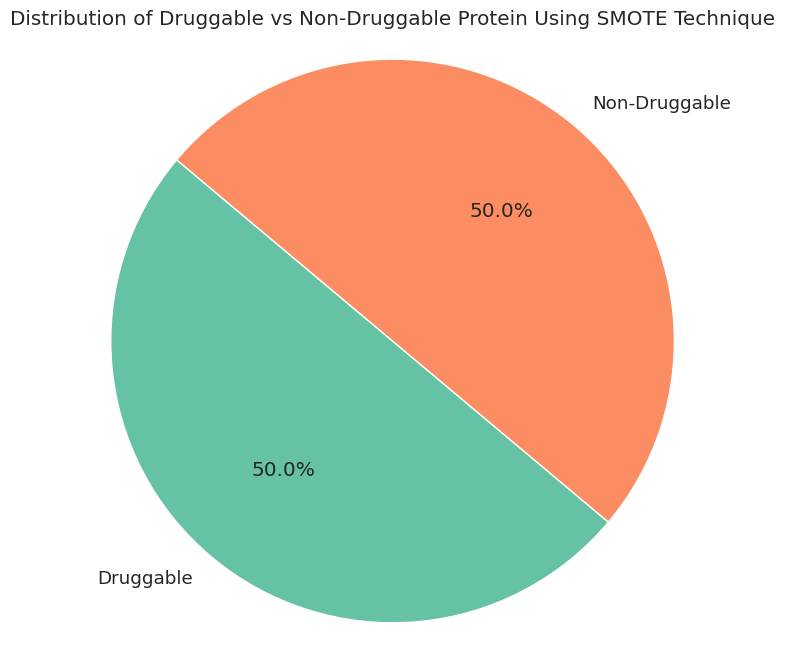

In [ ]:
druggable_counts = okk_1['is_druggable'].value_counts()
druggable_count = druggable_counts[1]
non_druggable_count = druggable_counts[0]

# Plotting
plt.figure(figsize=(8, 8))
plt.pie([druggable_count, non_druggable_count], labels=['Druggable', 'Non-Druggable'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
plt.title('Distribution of Druggable vs Non-Druggable Protein Using SMOTE Technique')
plt.axis('equal')
plt.show()

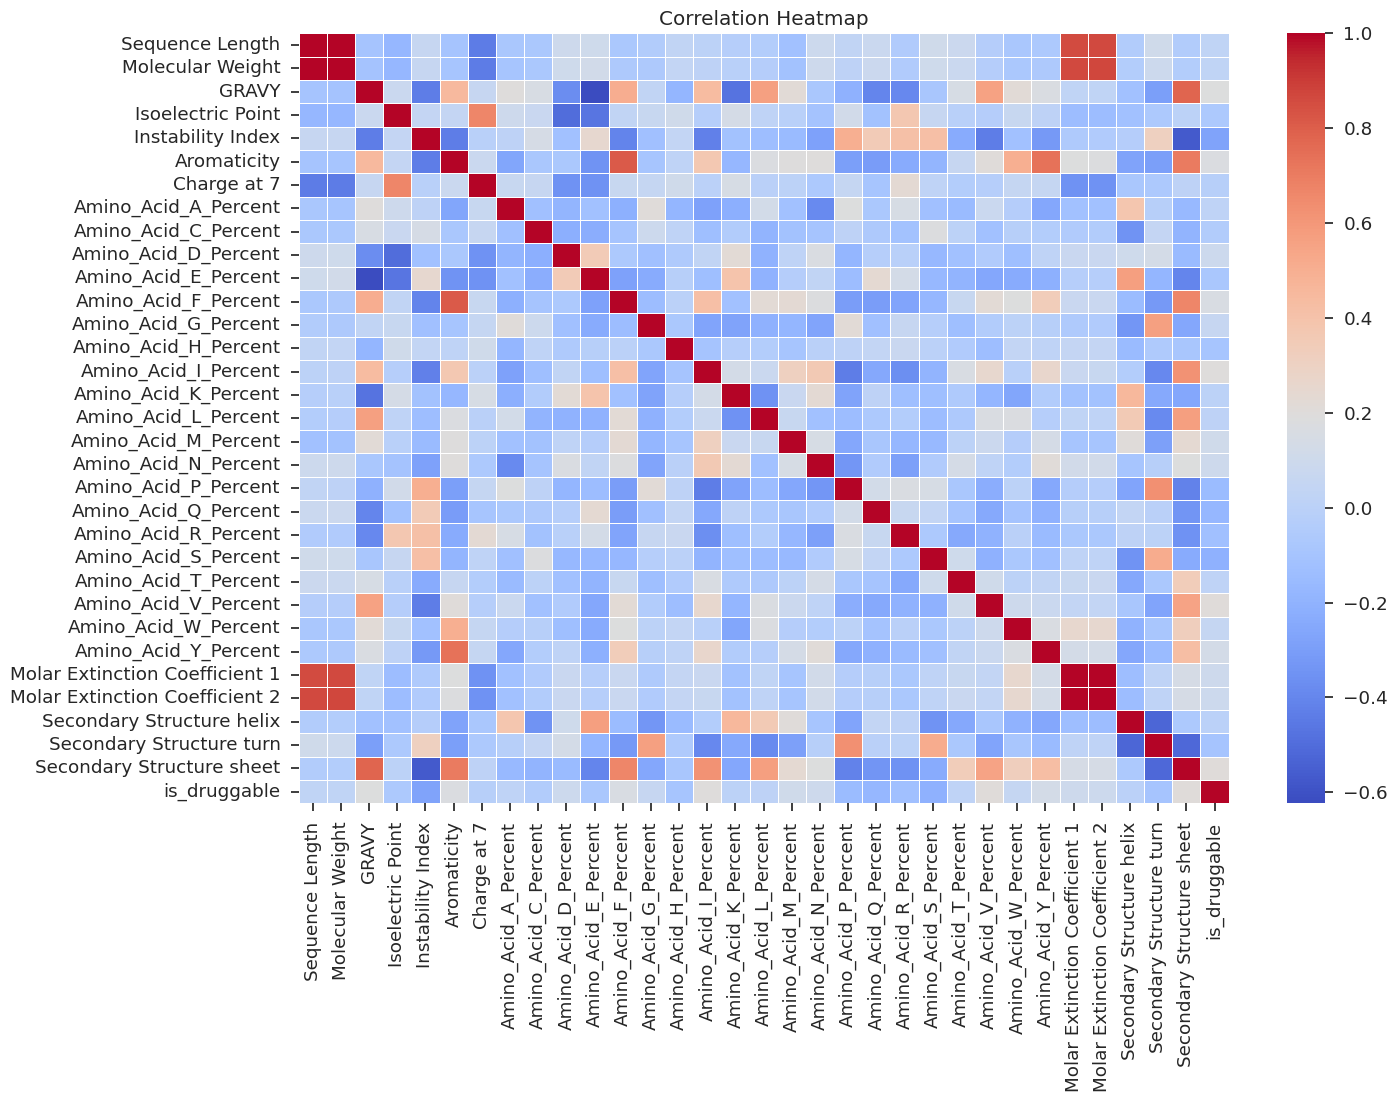

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(okk_1.corr(), cmap='coolwarm', annot=False, fmt=".2f",linewidth= 0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
okk_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34178 entries, 0 to 34177
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Sequence Length                 34178 non-null  float64
 1   Molecular Weight                34178 non-null  float64
 2   GRAVY                           34178 non-null  float64
 3   Isoelectric Point               34178 non-null  float64
 4   Instability Index               34178 non-null  float64
 5   Aromaticity                     34178 non-null  float64
 6   Charge at 7                     34178 non-null  float64
 7   Amino_Acid_A_Percent            34178 non-null  float64
 8   Amino_Acid_C_Percent            34178 non-null  float64
 9   Amino_Acid_D_Percent            34178 non-null  float64
 10  Amino_Acid_E_Percent            34178 non-null  float64
 11  Amino_Acid_F_Percent            34178 non-null  float64
 12  Amino_Acid_G_Percent            

In [ ]:
#PCA Analysis for reduction and selection of relevant ones

n_components = 21
pca_list = []
feature_weight_list = []
for i in range(1,n_components):
  PCAmod = PCA(n_components = i)
  PCAmod.fit(okk_1.iloc[:,7:27])
  pca_list.append(pd.Series({
      "n" : i,
      "model" : PCAmod,
      "var" : PCAmod.explained_variance_ratio_.sum(),
  }))
  weights = PCAmod.explained_variance_ratio_.reshape(-1, 1) / PCAmod.explained_variance_ratio_.sum()
  overall_contributions = np.abs(PCAmod.components_) * weights
  abs_feature_values = overall_contributions.sum(axis=0)
  feature_weight_list.append(pd.DataFrame({
      'n': i,
      'features': okk_1.iloc[:,7:27].columns,
      'values': abs_feature_values / abs_feature_values.sum(),
  }))
pca_report = pd.DataFrame(pca_list)
feature_importance_report = pd.concat(feature_weight_list).pivot(index='n', columns='features', values='values')

In [ ]:
pca_report

n                                              model       var
0    1  PCA(copy=True, iterated_power='auto', n_compon...  0.165645
1    2  PCA(copy=True, iterated_power='auto', n_compon...  0.295021
2    3  PCA(copy=True, iterated_power='auto', n_compon...  0.384353
3    4  PCA(copy=True, iterated_power='auto', n_compon...  0.450985
4    5  PCA(copy=True, iterated_power='auto', n_compon...  0.514097
5    6  PCA(copy=True, iterated_power='auto', n_compon...  0.565931
6    7  PCA(copy=True, iterated_power='auto', n_compon...  0.611792
7    8  PCA(copy=True, iterated_power='auto', n_compon...  0.655010
8    9  PCA(copy=True, iterated_power='auto', n_compon...  0.696071
9   10  PCA(copy=True, iterated_power='auto', n_compon...  0.735043
10  11  PCA(copy=True, iterated_power='auto', n_compon...  0.771800
11  12  PCA(copy=True, iterated_power='auto', n_compon...  0.806732
12  13  PCA(copy=True, iterated_power='auto', n_compon...  0.839795
13  14  PCA(copy=True, iterated_power='auto', n_compon...  0.870525
14  15  PCA(copy=True, iterated_power='auto', n_compon...  0.901026
15  16  PCA(copy=True, iterated_power='auto', n_compon...  0.930010
16  17  PCA(copy=True, iterated_power='auto', n_compon...  0.954771
17  18  PCA(copy=True, iterated_power='auto', n_compon...  0.978675
18  19  PCA(copy=True, iterated_power='auto', n_compon...  1.000000
19  20  PCA(copy=True, iterated_power='auto', n_compon...  1.000000

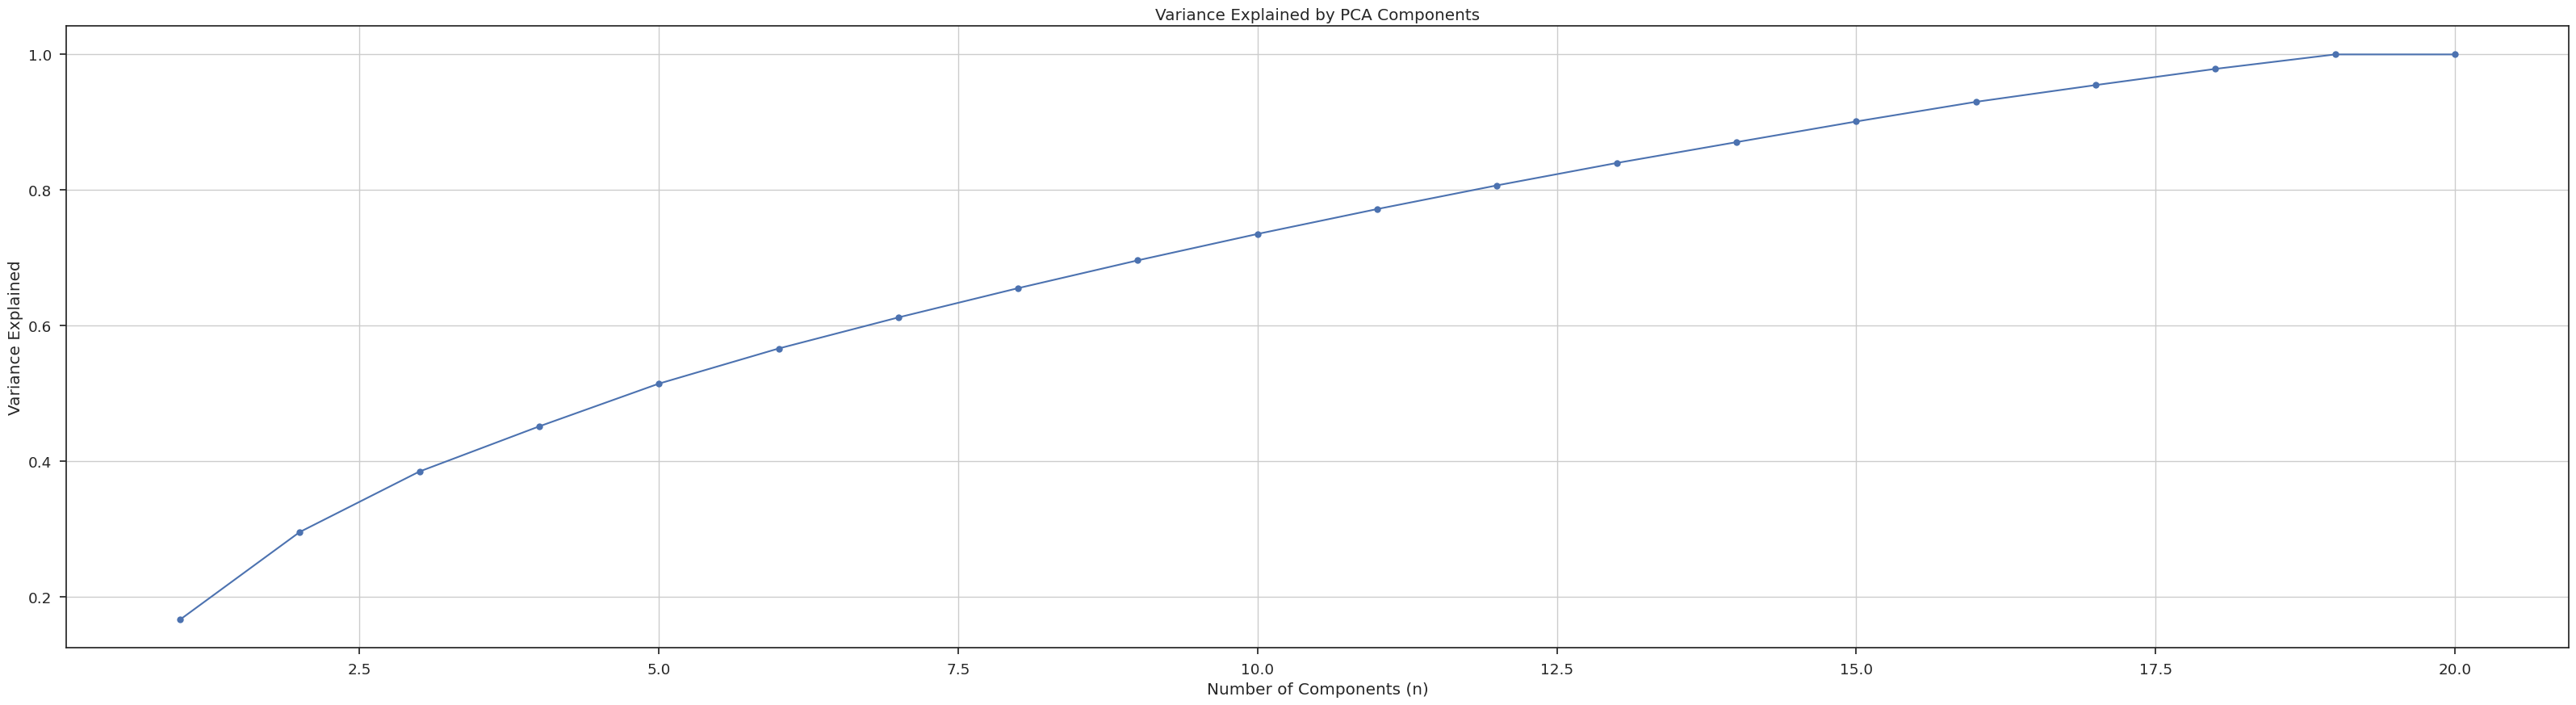

In [ ]:
fig,ax = plt.subplots(figsize = (40,10))
plt.plot(pca_report['n'], pca_report['var'], marker = 'o', linestyle = "-", color = 'b')
plt.title('Variance Explained by PCA Components')
# plt.axvline(x=150, color='r', linestyle='--', linewidth=2, label='Threshold at x=50')
plt.xlabel('Number of Components (n)')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

[Text(0.5, 0, 'Number of components'),
 Text(0, 0.5, 'Relative Importance'),
 Text(0.5, 1.0, 'Feature Importance Vs Dimensions')]

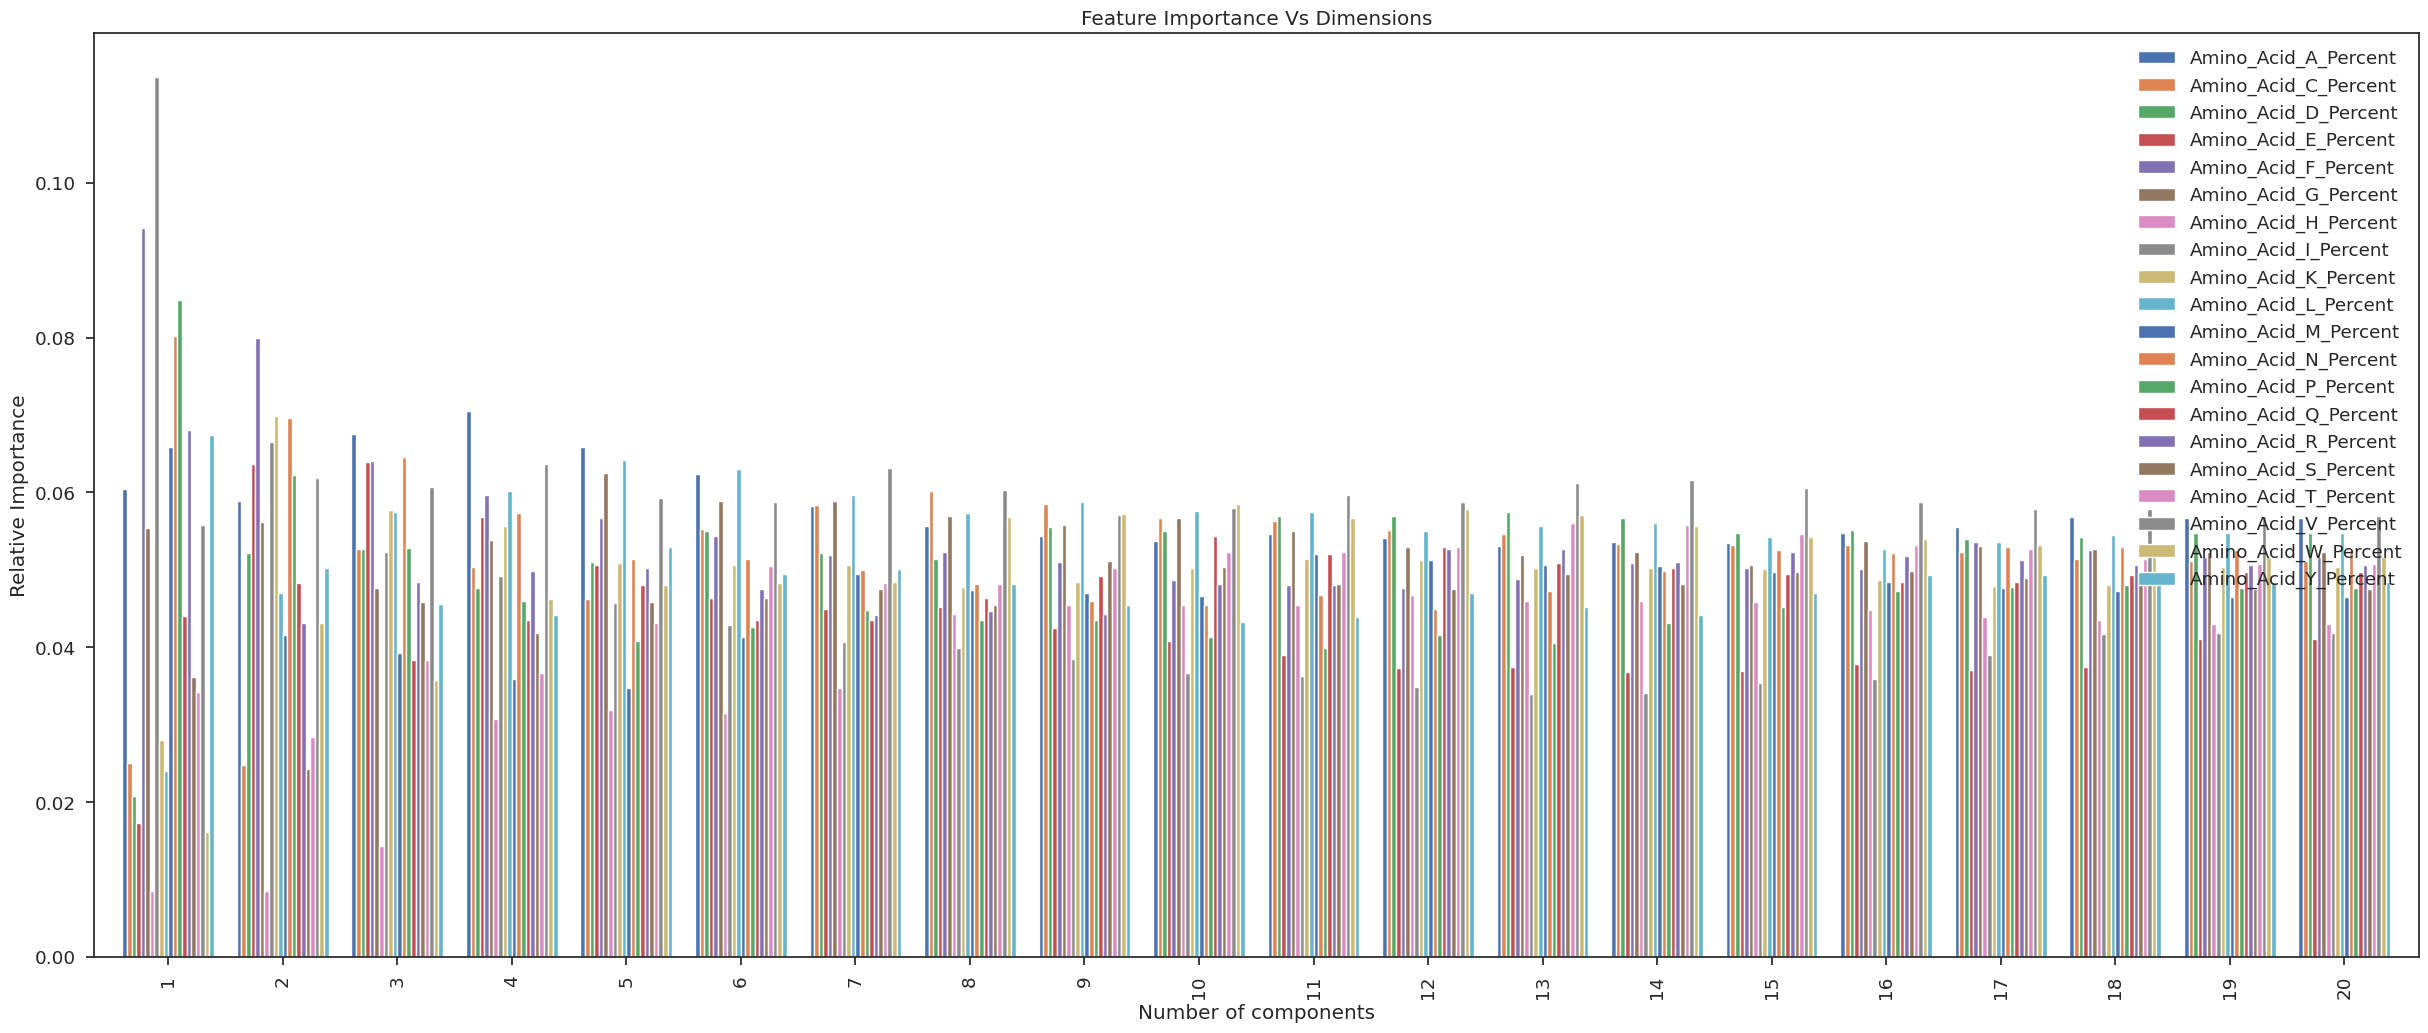

In [ ]:
ax = feature_importance_report.plot(kind = 'bar' , figsize = (30,12), width=0.8)
ax.legend(loc = 'upper right')
ax.set(xlabel = 'Number of components' ,  ylabel = 'Relative Importance' , title = 'Feature Importance Vs Dimensions')

<Figure size 2000x1200 with 0 Axes>

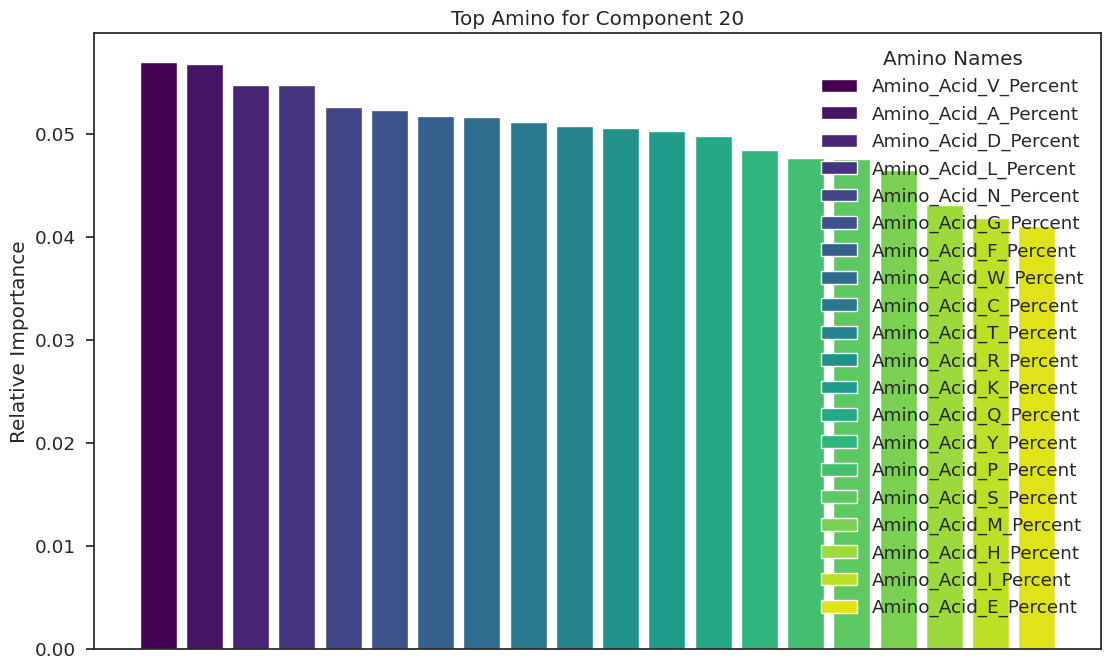

In [ ]:
plt.figure(figsize= (20,12))
n_top_amino = 20
top_amino_acids = feature_importance_report.iloc[19].nlargest(n_top_amino)
fig, ax = plt.subplots(figsize=(13, 8))

for idx, (amino, importance) in enumerate(top_amino_acids.items()):
    ax.bar(idx, importance, label=amino, color=plt.cm.viridis(idx / len(top_amino_acids)))

ax.set_xticks([])

ax.legend(loc='upper right', title='Amino Names')

ax.set(ylabel='Relative Importance', title='Top Amino for Component 20')
plt.show()

Amino_Acid_T_Percent              0.019468
Amino_Acid_V_Percent              0.020183
Isoelectric Point                 0.022205
Amino_Acid_F_Percent              0.022929
Amino_Acid_R_Percent              0.023450
Secondary Structure helix         0.023489
Amino_Acid_P_Percent              0.023784
Molar Extinction Coefficient 1    0.024230
Amino_Acid_E_Percent              0.024595
Amino_Acid_H_Percent              0.024637
Aromaticity                       0.024676
Amino_Acid_L_Percent              0.024876
Amino_Acid_K_Percent              0.024939
Amino_Acid_A_Percent              0.025172
GRAVY                             0.025407
Amino_Acid_I_Percent              0.025460
Amino_Acid_W_Percent              0.026084
Amino_Acid_Y_Percent              0.026556
Charge at 7                       0.026641
Amino_Acid_C_Percent              0.026986
Amino_Acid_D_Percent              0.027422
Amino_Acid_N_Percent              0.027604
Molar Extinction Coefficient 2    0.028197
Secondary S

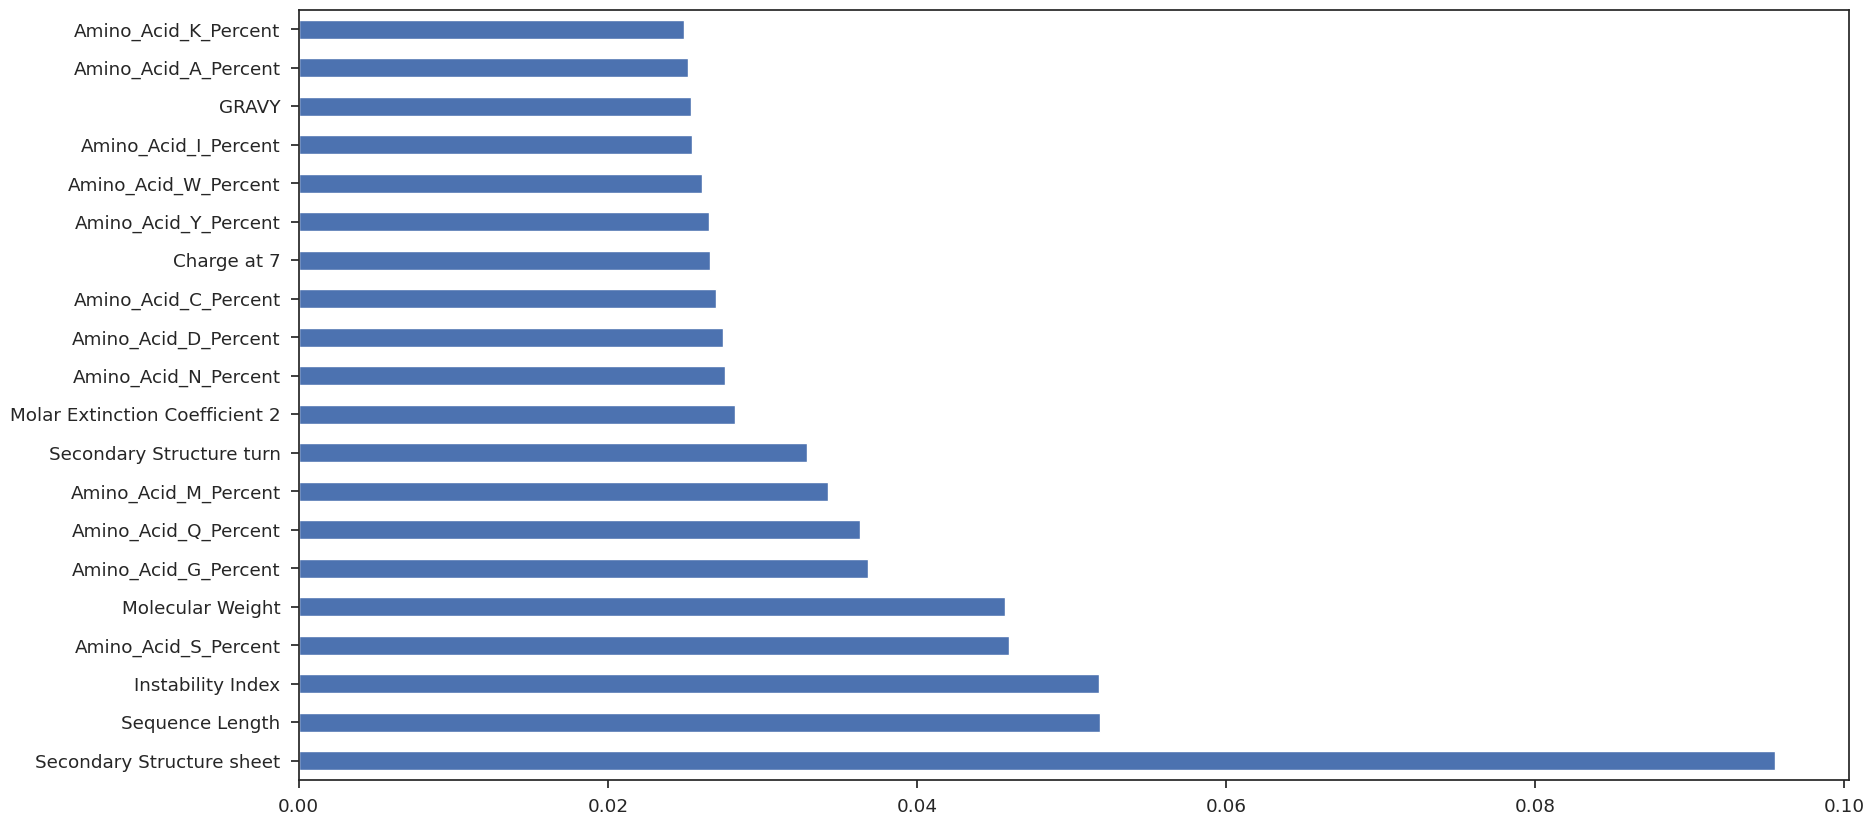

In [ ]:
#lets see each feature importance using XGB Classifier
import xgboost

x_sample = okk_1.drop(columns = ['is_druggable'])
y_sample = okk_1['is_druggable']

model = xgboost.XGBClassifier()
model.fit(x_sample,y_sample)

feat_imp = pd.Series(model.feature_importances_, index=x_sample.columns)
print(feat_imp.sort_values())
feat_imp.nlargest(20).plot(kind='barh',figsize=(20,10))

plt.show()

In [ ]:
#model building
X_train,X_test,y_train,y_test = train_test_split(x_sample,y_sample, test_size = 0.2, random_state = 123)
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#using xgboost boosting algorithms
model_1 = xgboost.XGBClassifier()
model_1.fit(X_train,y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic', ...)

In [ ]:
def test_results(y_pred, y_test):
  results = {}
  results['Accuracy'] = accuracy_score(y_test,y_pred)
  results['Precision'] = precision_score(y_test,y_pred,average = 'weighted')
  results['Recall'] = recall_score(y_test,y_pred,average = 'weighted')
  results['F1_Score'] = f1_score(y_test,y_pred,average = 'weighted')

  cm = confusion_matrix(y_test,y_pred)
  return results,cm

In [ ]:
y_pred = model_1.predict(X_test)
metrics_1,cm_1 = test_results(y_pred, y_test)

In [ ]:
#using logistic regression algorithm
model_2 = LogisticRegression()
model_2.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred_2 = model_2.predict(X_test)
metrics_2, cm_2 = test_results(y_pred_2, y_test)

In [207]:
#using SVM algorithm using various kernels
model_3 = svm.SVC(kernel = 'linear',probability = True)
model_4 = svm.SVC(kernel = 'poly',probability = True)
model_5 = svm.SVC(kernel = 'rbf',probability = True)

model_3.fit(X_train,y_train)
model_4.fit(X_train,y_train)
model_5.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [208]:
y_pred_3 = model_3.predict(X_test)
metrics_3, cm_3 = test_results(y_pred_3, y_test)

y_pred_4 = model_4.predict(X_test)
metrics_4, cm_4 = test_results(y_pred_4, y_test)

y_pred_5 = model_3.predict(X_test)
metrics_5, cm_5 = test_results(y_pred_5, y_test)

In [198]:
#using RandomForest with estimator = 1500 which is no of trees employed
model_6 = RandomForestClassifier(n_estimators = 1500, criterion = 'entropy', random_state = 42)
model_6.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=1500, n_jobs=None,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [199]:
y_pred_6 = model_6.predict(X_test)
metrics_6,cm_6 = test_results(y_pred_6,y_test)

In [187]:
#using ANN for classification
model_7 = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [188]:
history = model_7.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 50)

Epoch 1/50
855/855 [==============================] - 5s 4ms/step - loss: 0.5850 - accuracy: 0.7030 - val_loss: 0.5416 - val_accuracy: 0.7431
Epoch 2/50
855/855 [==============================] - 3s 3ms/step - loss: 0.5176 - accuracy: 0.7460 - val_loss: 0.5023 - val_accuracy: 0.7678
Epoch 3/50
855/855 [==============================] - 4s 5ms/step - loss: 0.4809 - accuracy: 0.7750 - val_loss: 0.4694 - val_accuracy: 0.7822
Epoch 4/50
855/855 [==============================] - 4s 4ms/step - loss: 0.4502 - accuracy: 0.7924 - val_loss: 0.4497 - val_accuracy: 0.7913
Epoch 5/50
855/855 [==============================] - 3s 3ms/step - loss: 0.4216 - accuracy: 0.8082 - val_loss: 0.4553 - val_accuracy: 0.7967
Epoch 6/50
855/855 [==============================] - 3s 4ms/step - loss: 0.4030 - accuracy: 0.8169 - val_loss: 0.4235 - val_accuracy: 0.8104
Epoch 7/50
855/855 [==============================] - 4s 4ms/step - loss: 0.3765 - accuracy: 0.8341 - val_loss: 0.4179 - val_accuracy: 0.8173
Epoch 

In [189]:
y_pred_7 = model_7.predict(X_test)
y_pred_7 = (y_pred_7 >= 0.5).astype(int)
metrics_7,cm_7 = test_results(y_pred_7,y_test)

214/214 [==============================] - 0s 2ms/step


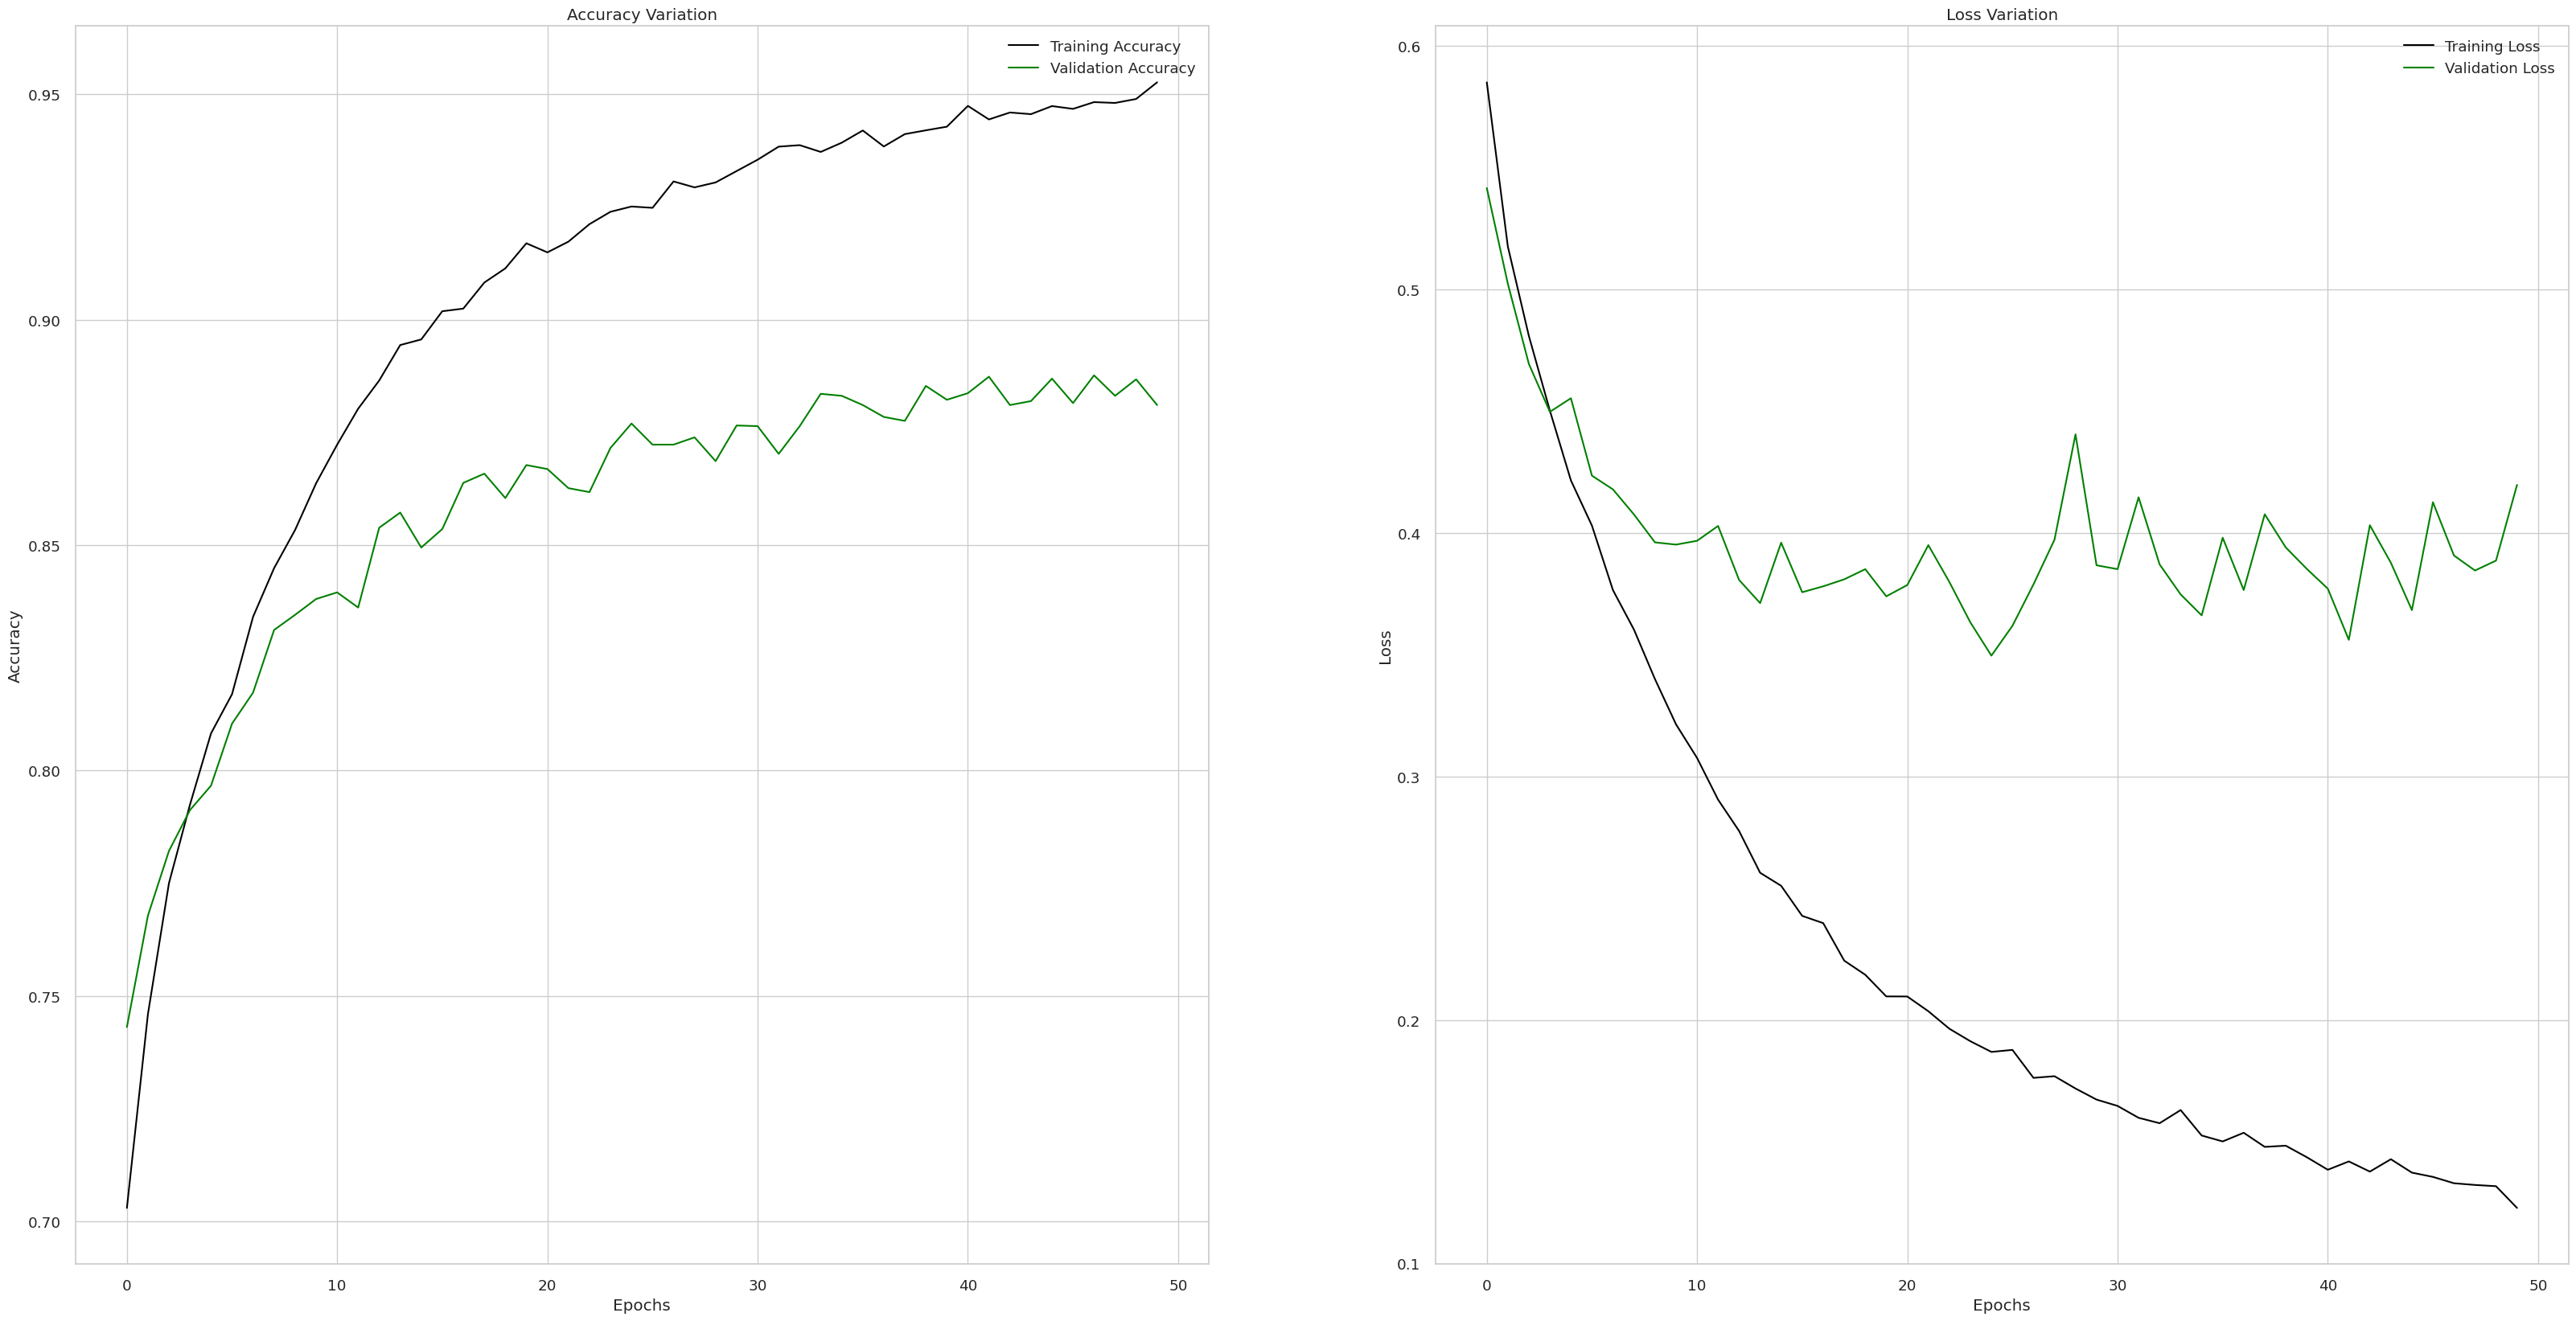

In [190]:
fig,ax = plt.subplots(figsize = (40,20), ncols = 2)
ax[0].plot(history.history['accuracy'],color = 'black', label = 'Training Accuracy')
ax[0].plot(history.history['val_accuracy'],color = 'green', label = 'Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Accuracy Variation')
ax[0].legend()

ax[1].plot(history.history['loss'],color = 'black', label = 'Training Loss')
ax[1].plot(history.history['val_loss'],color = 'green', label = 'Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Loss Variation')
ax[1].legend()
plt.show()

In [209]:
model_list = {
    "XGBoost" : pd.Series(metrics_1),
    "Logistic_Regression" : pd.Series(metrics_2),
    "SVM_Linear" : pd.Series(metrics_3),
    "SVM_Polynomial" : pd.Series(metrics_4),
    "SVM_RBF" : pd.Series(metrics_5),
    "Random_Forest" : pd.Series(metrics_6),
    "ANN" : pd.Series(metrics_7)
}

pd.DataFrame(model_list).T


Accuracy  Precision    Recall  F1_Score
XGBoost              0.852984   0.854487  0.852984  0.852808
Logistic_Regression  0.663107   0.663636  0.663107  0.662762
SVM_Linear           0.668227   0.671448  0.668227  0.666500
SVM_Polynomial       0.746197   0.777554  0.746197  0.738601
SVM_RBF              0.668227   0.671448  0.668227  0.666500
Random_Forest        0.892920   0.893853  0.892920  0.892846
ANN                  0.881071   0.886184  0.881071  0.880648

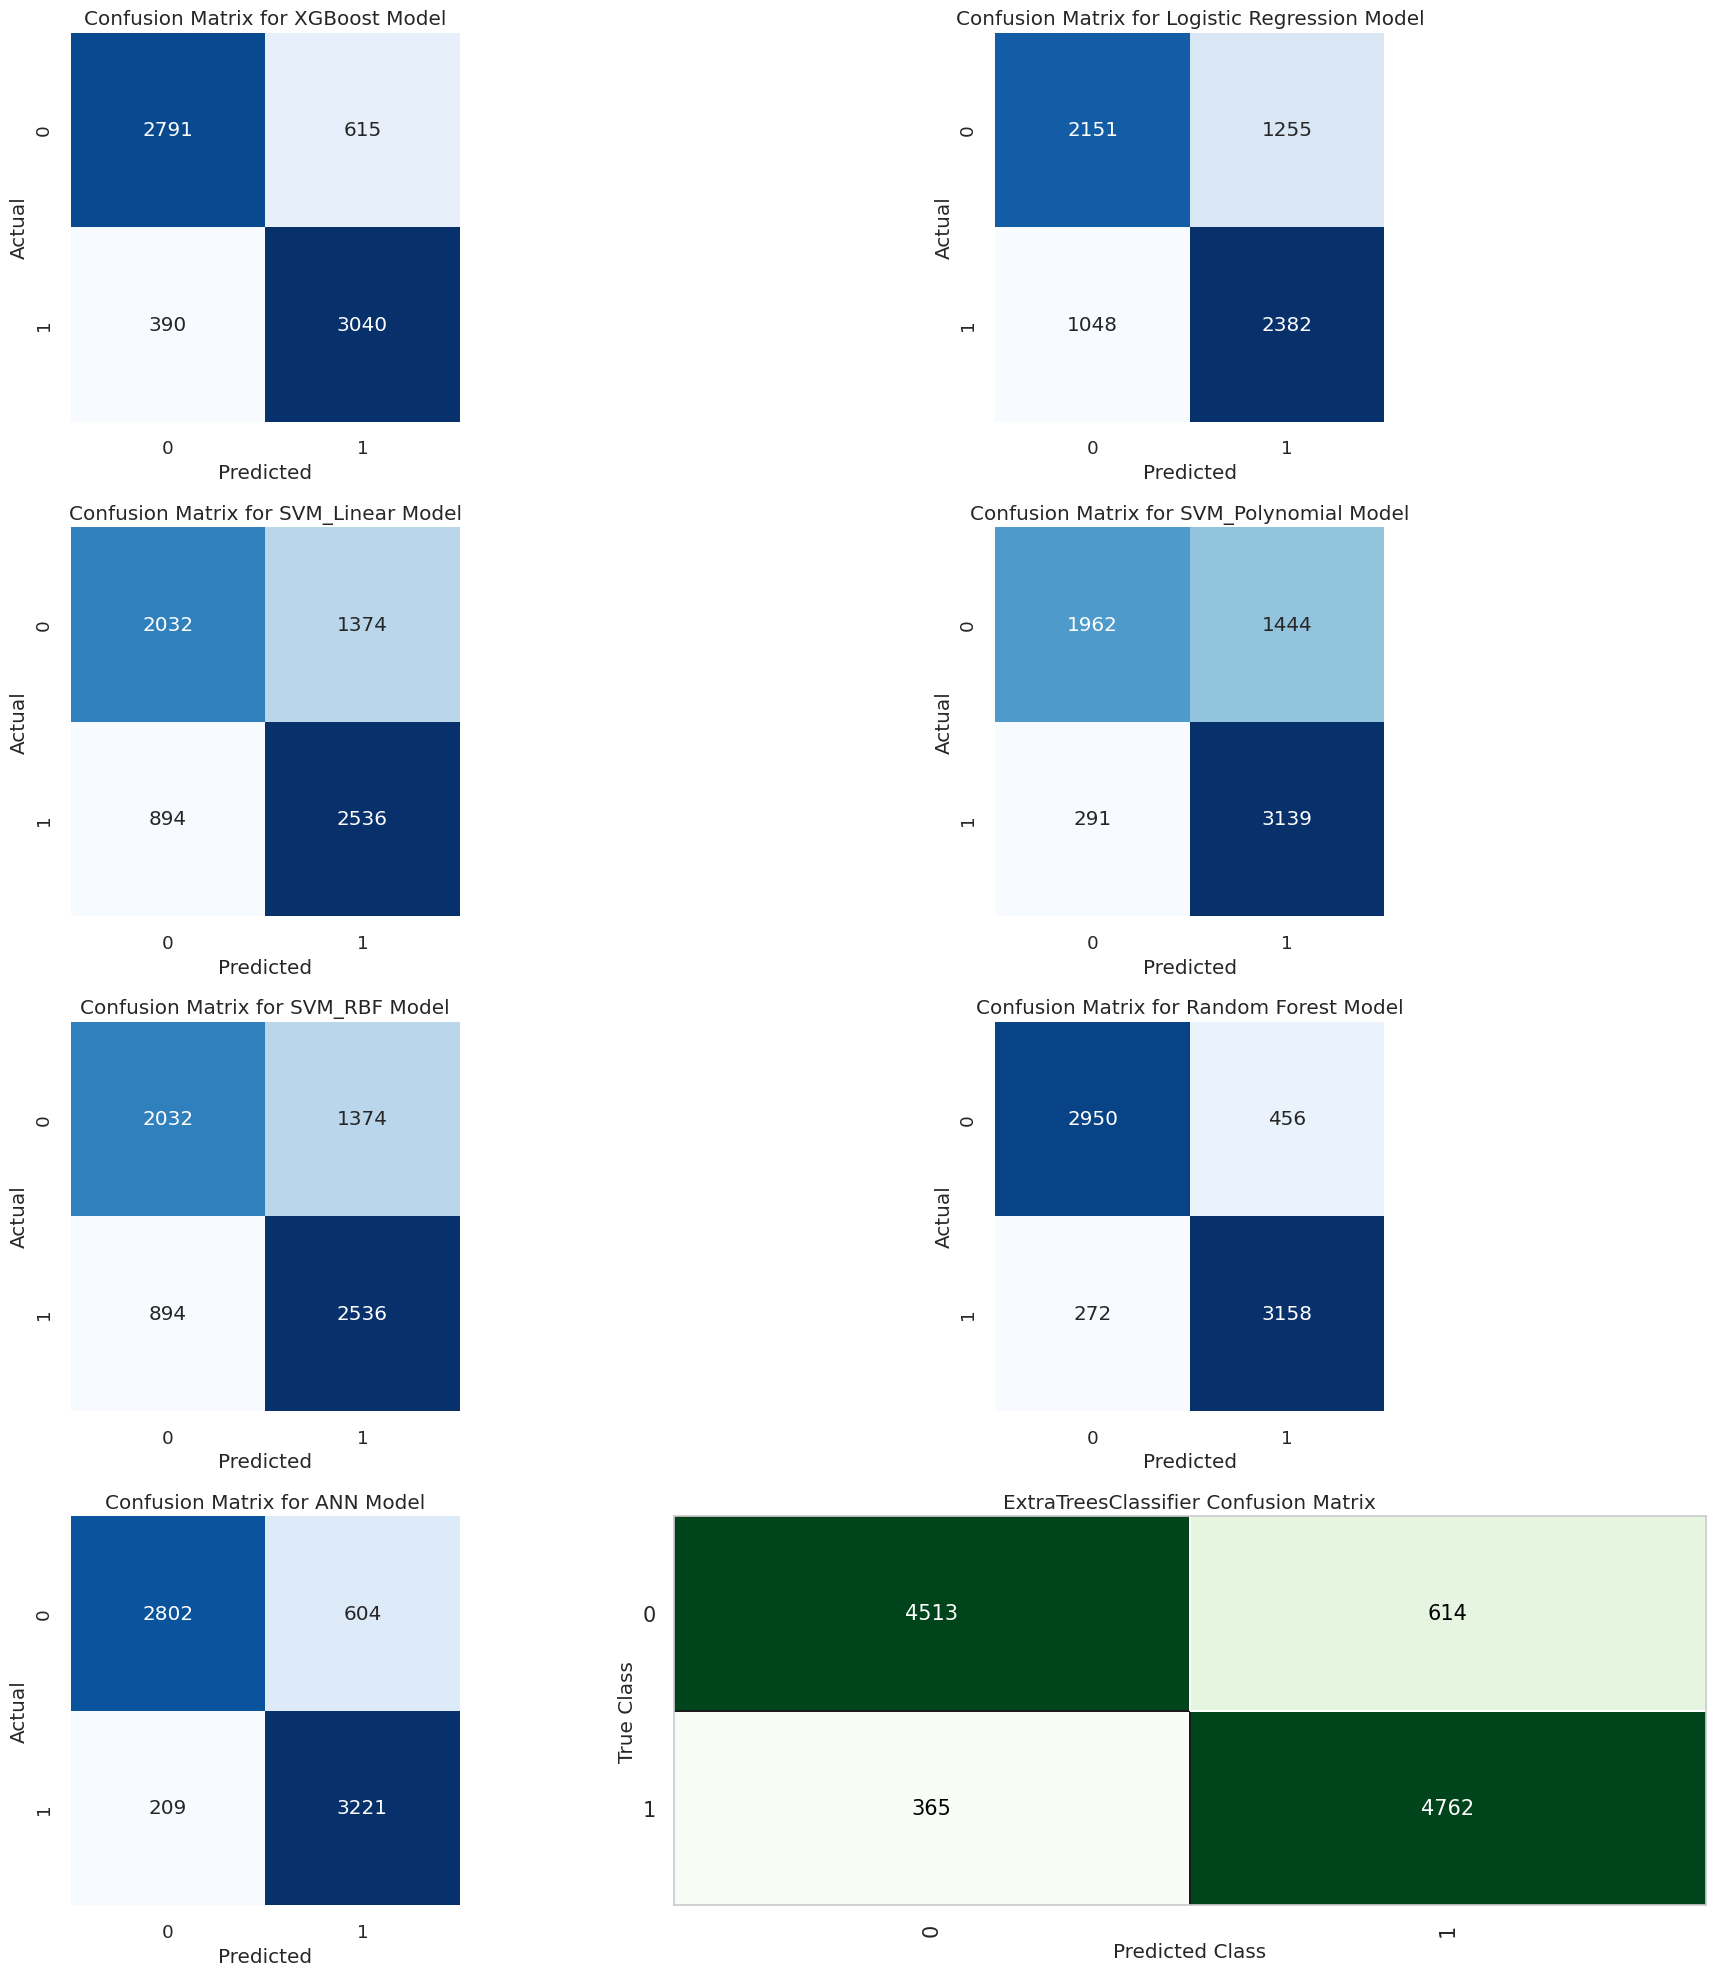

<Figure size 800x550 with 0 Axes>

In [196]:
fig,ax = plt.subplots(figsize = (20,20), nrows = 4,ncols = 2)
sns.set(font_scale=1.2)  # Adjust font size if needed
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,ax = ax[0][0])
ax[0][0].set_xlabel('Predicted')
ax[0][0].set_ylabel('Actual')
ax[0][0].set_title('Confusion Matrix for XGBoost Model')

sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,ax = ax[0][1])
ax[0][1].set_xlabel('Predicted')
ax[0][1].set_ylabel('Actual')
ax[0][1].set_title('Confusion Matrix for Logistic Regression Model')

sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,ax = ax[1][0])
ax[1][0].set_xlabel('Predicted')
ax[1][0].set_ylabel('Actual')
ax[1][0].set_title('Confusion Matrix for SVM_Linear Model')

sns.heatmap(cm_4, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,ax = ax[1][1])
ax[1][1].set_xlabel('Predicted')
ax[1][1].set_ylabel('Actual')
ax[1][1].set_title('Confusion Matrix for SVM_Polynomial Model')

sns.heatmap(cm_5, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,ax = ax[2][0])
ax[2][0].set_xlabel('Predicted')
ax[2][0].set_ylabel('Actual')
ax[2][0].set_title('Confusion Matrix for SVM_RBF Model')

sns.heatmap(cm_6, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,ax = ax[2][1])
ax[2][1].set_xlabel('Predicted')
ax[2][1].set_ylabel('Actual')
ax[2][1].set_title('Confusion Matrix for Random Forest Model')

sns.heatmap(cm_7, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,ax = ax[3][0])
ax[3][0].set_xlabel('Predicted')
ax[3][0].set_ylabel('Actual')
ax[3][0].set_title('Confusion Matrix for ANN Model')

plot_model(best_models , plot = "confusion_matrix")
ax[3][1].set_xlabel('Predicted')
ax[3][1].set_ylabel('Actual')
ax[3][1].set_title('Confusion Matrix for Extra Trees Classifier Model using Pycaret AutoML')

plt.tight_layout()
plt.show()

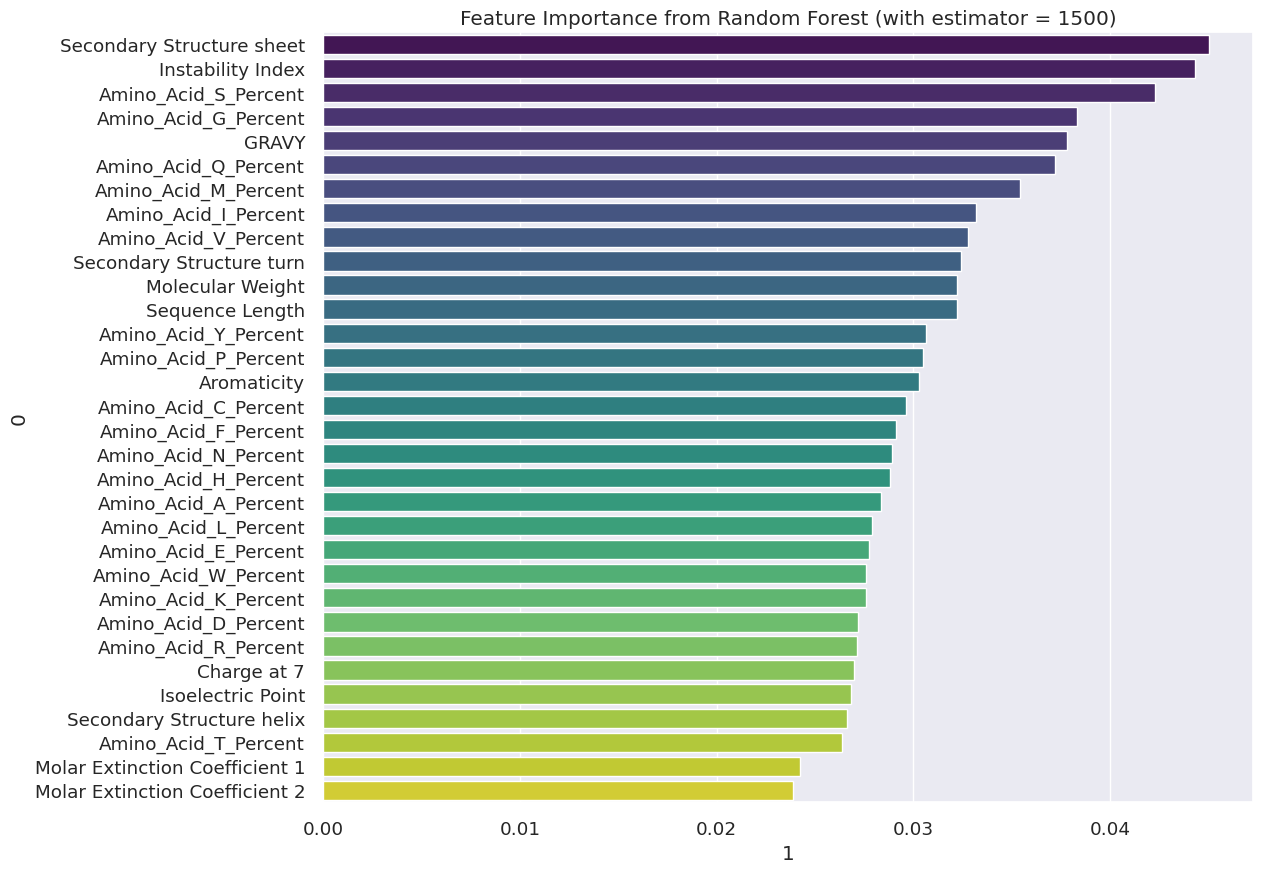

In [200]:
feature_importance = model_6.feature_importances_
okk = pd.DataFrame([x_sample.columns, feature_importance]).T
okk = okk.sort_values(by = 1,ascending = False)
plt.figure(figsize=(12, 10))
sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')
plt.title("Feature Importance from Random Forest (with estimator = 1500)")
plt.show()

In [193]:
import pycaret
pycaret.__version__

'3.3.0'

In [194]:
from pycaret.classification import *
setup(data = x_sample, target = y_sample, session_id = 123)
best_models = compare_models()

Processing:   0%|          | 0/65 [00:00<?, ?it/s]

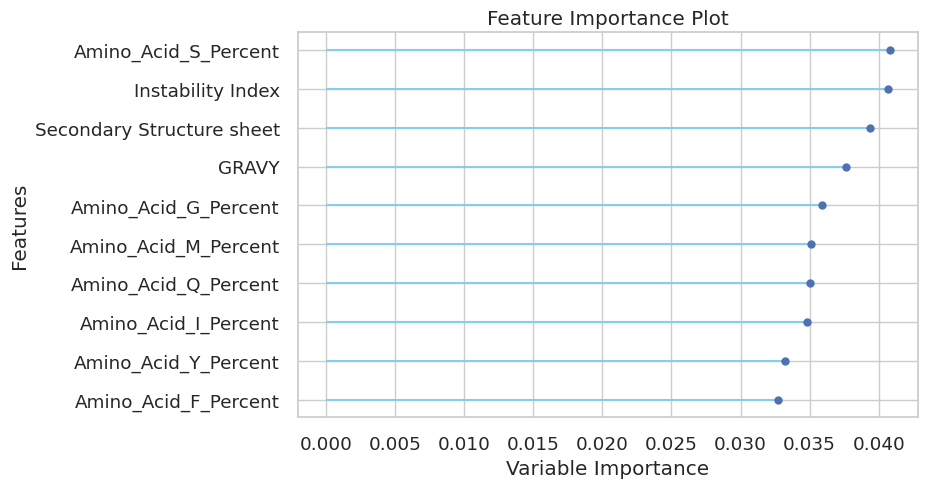

In [195]:
plot_model(best_models, plot = 'feature')

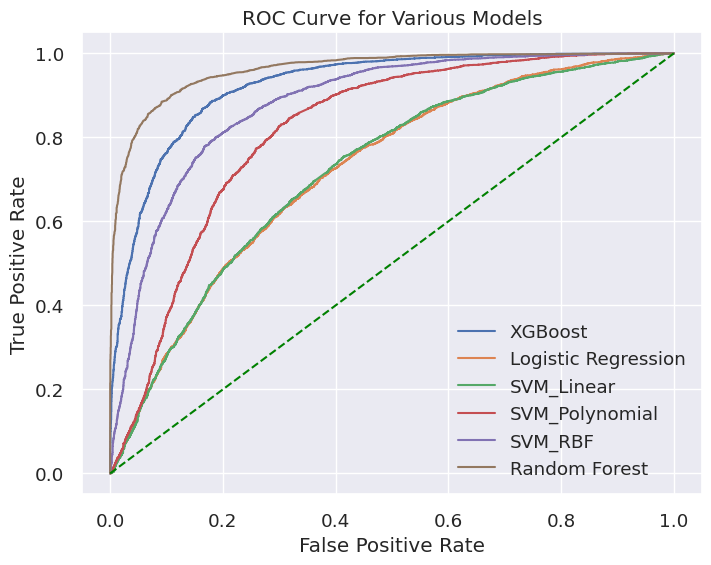

In [220]:
#roc-auc curve for various algorithm
fpr_1, tpr_1, _ = roc_curve(y_test, model_1.predict_proba(X_test)[:, 1])
fpr_2, tpr_2, _ = roc_curve(y_test, model_2.predict_proba(X_test)[:, 1])
fpr_3, tpr_3, _ = roc_curve(y_test, model_3.predict_proba(X_test)[:, 1])
fpr_4, tpr_4, _ = roc_curve(y_test, model_4.predict_proba(X_test)[:, 1])
fpr_5, tpr_5, _ = roc_curve(y_test, model_5.predict_proba(X_test)[:, 1])
fpr_6, tpr_6, _ = roc_curve(y_test, model_6.predict_proba(X_test)[:, 1])

# Plot ROC curves for each model
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, label='XGBoost')
plt.plot(fpr_2, tpr_2, label='Logistic Regression')
plt.plot(fpr_3, tpr_3, label='SVM_Linear')
plt.plot(fpr_4, tpr_4, label='SVM_Polynomial')
plt.plot(fpr_5, tpr_5, label='SVM_RBF')
plt.plot(fpr_6, tpr_6, label='Random Forest')


# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Various Models')
plt.legend()
plt.show()

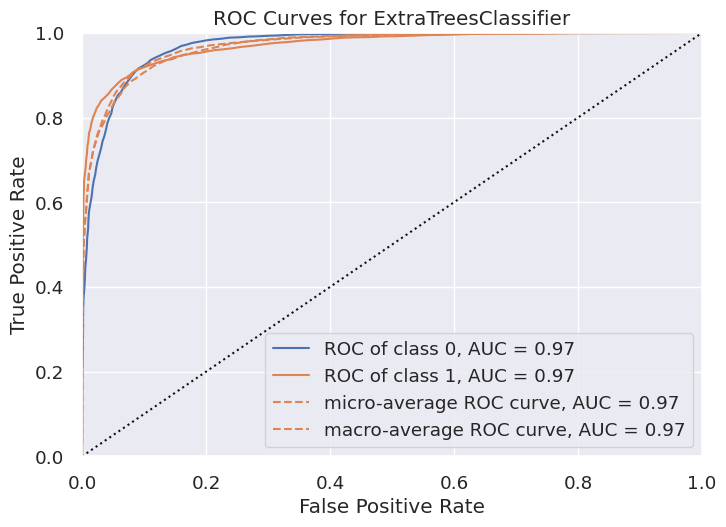

In [222]:
plot_model(best_models, plot = 'auc')